In [1]:
from Extract_ephys_from_struct import ExtractEphysData, calculate_mean_responses, ResponseDistributionPlotter

#from plotting_functions import plot_spike_distribution_boxplots, plot_spike_distribution, plot_psth, plot_raster

#now test the class
#initialize the class
EED = ExtractEphysData('/Users/cresp1el/Documents/MATLAB/lmc_20ms_data.mat')

#test the methods of the class
EED.load_matfiles_printdata()

#test the extract_ephys_data method
# EED.extract_ephys_data('Lmc_opsin', 'lmc_ch_1_3094_rec1', 'cid134')

#what are the group names?

EED.group_names

dict_keys(['Lmc_noopsin', 'Lmc_opsin'])
For the group Lmc_noopsin there are 2 mice
For the recording lmc_noch_1_3096_rec1 there are 5 cells
For the recording lmc_noch_1_3096_rec2 there are 4 cells
For the group Lmc_opsin there are 3 mice
For the recording lmc_ch_1_3094_rec1 there are 7 cells
For the recording lmc_ch_1_3094_rec2 there are 3 cells
For the recording lmc_ch_2_3093_rec1 there are 4 cells


dict_keys(['Lmc_noopsin', 'Lmc_opsin'])

In [71]:
test = calculate_mean_responses(EED)

In [72]:
print(test.keys()) #these are the group names
print(test['Lmc_opsin'].keys()) #these are the pre and post epoch names for each group
print(test['Lmc_opsin']['Pre']) #these are the cell names for each epoch

dict_keys(['Lmc_noopsin', 'Lmc_opsin'])
dict_keys(['Pre', 'Post'])
[{'Recording': 'lmc_ch_1_3094_rec1', 'CellID': 'cid134', 'Pre_Zero_early': 0.0975609756097561, 'Pre_Zero_late': 1.991869918699187, 'Pre_Low_early': 0.13846153846153847, 'Pre_Low_late': 1.4, 'Pre_Mid_early': 0.17777777777777778, 'Pre_Mid_late': 1.962962962962963, 'Pre_Max_early': 0.15789473684210525, 'Pre_Max_late': 1.7982456140350878, 'Pre_Pooled_early': 0.158311345646438, 'Pre_Pooled_late': 1.720316622691293, 'Post_Zero_early': 0.12962962962962962, 'Post_Zero_late': 1.5277777777777777, 'Post_Low_early': 0.06779661016949153, 'Post_Low_late': 1.652542372881356, 'Post_Mid_early': 0.03731343283582089, 'Post_Mid_late': 1.8208955223880596, 'Post_Max_early': 0.12903225806451613, 'Post_Max_late': 1.653225806451613, 'Post_Pooled_early': 0.07712765957446809, 'Post_Pooled_late': 1.7127659574468086}, {'Recording': 'lmc_ch_1_3094_rec1', 'CellID': 'cid145', 'Pre_Zero_early': 0.37398373983739835, 'Pre_Zero_late': 5.5528455284552845, 

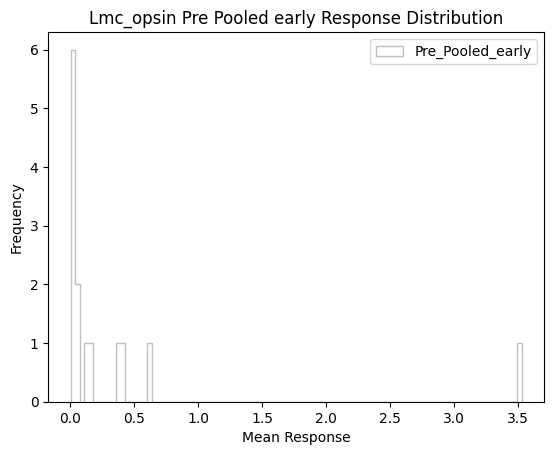

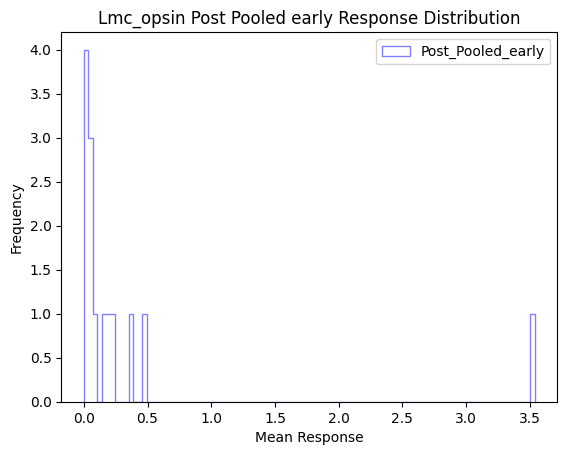

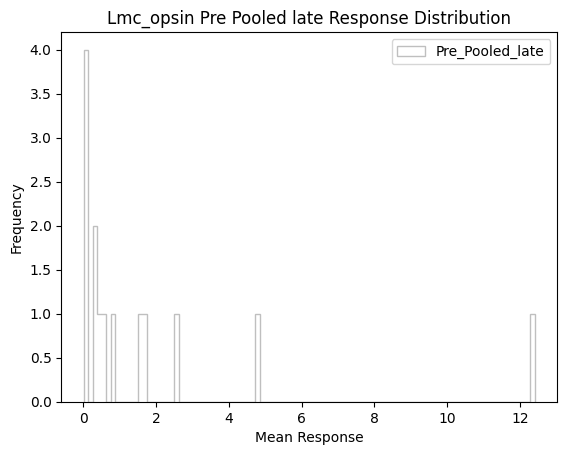

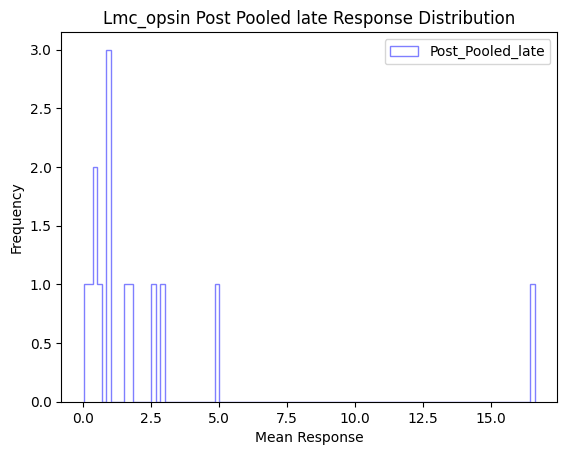

In [73]:
# Assuming `mean_responses_data` is the dictionary obtained from the calculate_mean_responses function
plotter = ResponseDistributionPlotter(test)
plotter.plot_distribution('Lmc_opsin', 'Pre', 'Pooled', bins=100, overlay=True, phase='early') 
plotter.plot_distribution('Lmc_opsin', 'Post', 'Pooled', bins=100, overlay=True, phase='early')

# Assuming `mean_responses_data` is the dictionary obtained from the calculate_mean_responses function
plotter = ResponseDistributionPlotter(test)
plotter.plot_distribution('Lmc_opsin', 'Pre', 'Pooled', bins=100, overlay=True, phase='late') 
plotter.plot_distribution('Lmc_opsin', 'Post', 'Pooled', bins=100, overlay=True, phase='late')

KeyError: None

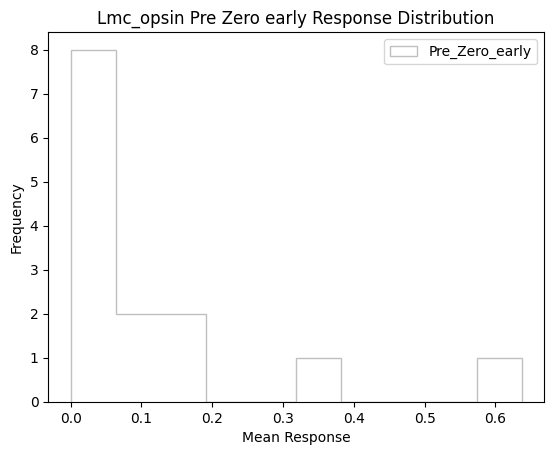

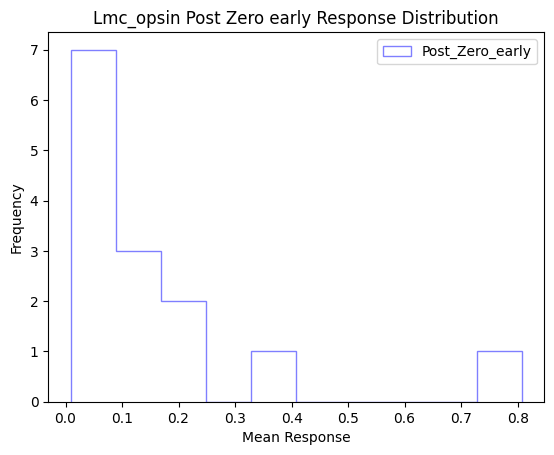

In [75]:

# plotter.plot_distribution('Lmc_opsin', epoch=None, stim_level='Zero', overlay=True)
#plot the distribution for pre and post stim levels separately
plotter.plot_distribution('Lmc_opsin', epoch='Pre', stim_level='Zero', overlay=True)
plotter.plot_distribution('Lmc_opsin', epoch='Post', stim_level='Zero', overlay=True)

# Plotting 'Pre' and 'Post' distributions on top of each other by setting overlay=True 
#loop over the 'Zero', 'Low', 'Mid', 'Max', or 'Pooled' stim levels to plot the distributions for each stim level
for stim_level in ['Zero', 'Low', 'Mid', 'Max', 'Pooled']: 
    plotter.plot_distribution('Lmc_opsin', epoch=None, stim_level=stim_level, overlay=True)
    
    

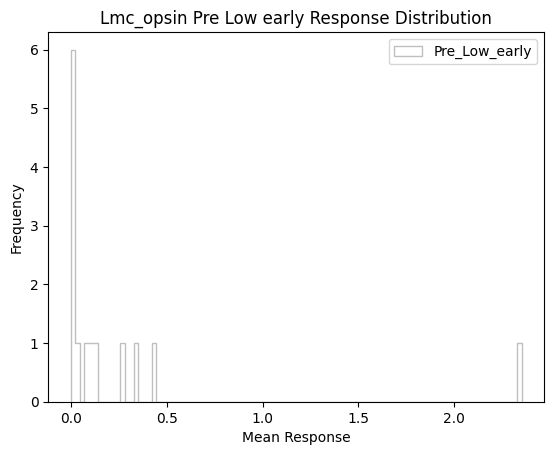

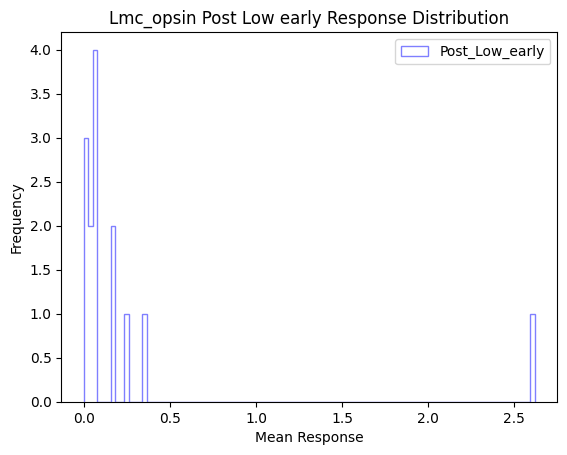

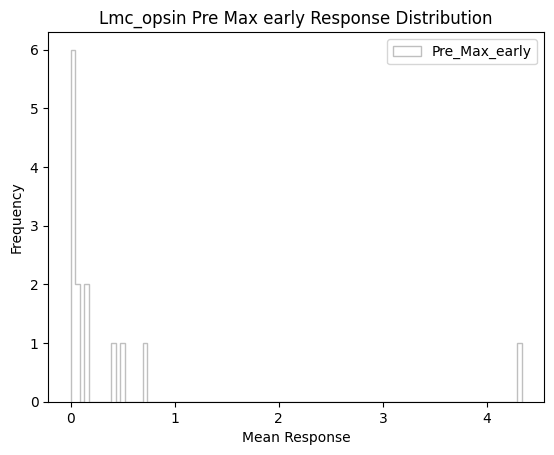

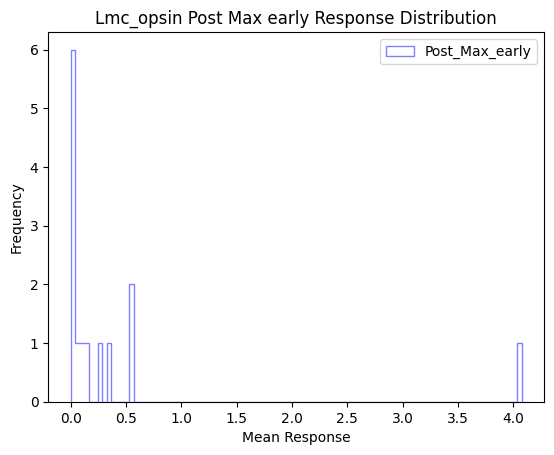

In [76]:
#plot the pre and post for the low separated 
plotter.plot_distribution('Lmc_opsin', epoch='Pre', stim_level='Low', bins=100)
plotter.plot_distribution('Lmc_opsin', epoch='Post', stim_level='Low', bins=100)

#plot the pre and post for the high separated
plotter.plot_distribution('Lmc_opsin', epoch='Pre', stim_level='Max', bins=100)
plotter.plot_distribution('Lmc_opsin', epoch='Post', stim_level='Max', bins=100)


In [77]:
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_box_and_whisker(data, group_name, stim_levels=['Zero', 'Low', 'Mid', 'Max', 'Pooled'], epoch='both', overlay=False):
    """
    Plots a box and whisker plot of the mean responses for the specified group and stimulation levels.

    Parameters:
    - data (dict): The data dictionary containing the mean responses.
    - group_name (str): The name of the group to plot data for.
    - stim_levels (list or str): The stimulation levels to plot data for (e.g., ['Zero', 'Low', 'Mid', 'Max', 'Pooled'] or 'Zero'). Default is all levels.
    - epoch (str): The epoch to plot data for ('Pre', 'Post', or 'both'). Default is 'both'.
    - overlay (bool): Whether to overlay the 'Pre' and 'Post' data on a single plot. Default is False.
    """

    if isinstance(stim_levels, str):
        stim_levels = [stim_levels]

    # Get the mean responses for the specified group
    group_data = data[group_name]

    # Get the data to plot
    data_to_plot = defaultdict(list)
    epochs_to_plot = ['Pre', 'Post'] if epoch == 'both' else [epoch]
    for epoch in epochs_to_plot:
        for stim_level in stim_levels:
            stim_data = [unit_data[f'{epoch}_{stim_level}'] for unit_data in group_data[epoch]]
            data_to_plot[epoch].append(stim_data)

    # Create a new figure
    plt.figure()

    # Create a box plot for each epoch
    colors = {'Pre': 'grey', 'Post': 'blue'}
    for i, (epoch, stim_data) in enumerate(data_to_plot.items()):
        position = range(i * (len(stim_levels) + 1) + 1, (i + 1) * (len(stim_levels) + 1))
        bp = plt.boxplot(stim_data, positions=position, labels=stim_levels if i == 0 else [''] * len(stim_levels), patch_artist=True)
        
        # Set colors
        for box in bp['boxes']:
            box.set_facecolor(colors[epoch])
        
    # Set the plot title and labels
    plt.title(f'{group_name} Mean Responses')
    plt.ylabel('Mean Response')
    plt.xlabel('Stimulation Level')
    
    # Adding epoch labels
    if epoch == 'both':
        mid_point = len(stim_levels) / 2
        plt.text(mid_point, plt.gca().get_ylim()[1], 'Pre', ha='center', va='center', fontsize=12, fontweight='bold')
        plt.text(len(stim_levels) + 1 + mid_point, plt.gca().get_ylim()[1], 'Post', ha='center', va='center', fontsize=12, fontweight='bold')

    # Show the plot
    if not overlay:
        plt.show()

# Usage example:
# Assuming `data_dict` is your data dictionary obtained from `calculate_mean_responses` function
plot_box_and_whisker(test, 'Lmc_opsin', 'Zero', 'both')





KeyError: 'Pre_Zero'

In [78]:
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_box_and_whisker(data, group_name, stim_levels=['Zero', 'Low', 'Mid', 'Max', 'Pooled'], epoch='both', overlay=False):
    """
    Plots a box and whisker plot of the mean responses for the specified group and stimulation levels.

    Parameters:
    - data (dict): The data dictionary containing the mean responses.
    - group_name (str): The name of the group to plot data for.
    - stim_levels (list or str): The stimulation levels to plot data for (e.g., ['Zero', 'Low', 'Mid', 'Max', 'Pooled'] or 'Zero'). Default is all levels.
    - epoch (str): The epoch to plot data for ('Pre', 'Post', or 'both'). Default is 'both'.
    - overlay (bool): Whether to overlay the 'Pre' and 'Post' data on a single plot. Default is False.
    """

    if isinstance(stim_levels, str):
        stim_levels = [stim_levels]

    # Get the mean responses for the specified group
    group_data = data[group_name]

    # Get the data to plot
    data_to_plot = defaultdict(list)
    epochs_to_plot = ['Pre', 'Post'] if epoch == 'both' else [epoch]
    for epoch in epochs_to_plot:
        for stim_level in stim_levels:
            stim_data = [unit_data[f'{epoch}_{stim_level}'] for unit_data in group_data[epoch]]
            data_to_plot[epoch].append(stim_data)

    # Create a new figure
    plt.figure()

    # Create a box plot for each epoch
    colors = {'Pre': 'grey', 'Post': 'blue'}
    for i, (epoch, stim_data) in enumerate(data_to_plot.items()):
        position = range(i * (len(stim_levels) + 1) + 1, (i + 1) * (len(stim_levels) + 1))
        labels = [f'{epoch}{level}' for level in stim_levels]
        bp = plt.boxplot(stim_data, positions=position, labels=labels, patch_artist=True)
        
        # Set colors
        for box in bp['boxes']:
            box.set_facecolor(colors[epoch])
        
    # Set the plot title and labels
    plt.title(f'{group_name} Mean Responses')
    plt.ylabel('Mean Response')
    plt.xlabel('Stimulation Level Epoch')
    
    # Show the plot
    if not overlay:
        plt.show()



# Usage example:

# Assuming `data_dict` is your data dictionary obtained from `calculate_mean_responses` function
plot_box_and_whisker(test, 'Lmc_opsin', 'Max', 'both')


KeyError: 'Pre_Max'

In [79]:
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_box_and_whisker(data, group_name, stim_levels=['Zero', 'Low', 'Mid', 'Max', 'Pooled'], epoch='both', overlay=False, plot_hist=False):
    """
    Plots a box and whisker plot of the mean responses for the specified group and stimulation levels.

    Parameters:
    - data (dict): The data dictionary containing the mean responses.
    - group_name (str): The name of the group to plot data for.
    - stim_levels (list or str): The stimulation levels to plot data for (e.g., ['Zero', 'Low', 'Mid', 'Max', 'Pooled'] or 'Zero'). Default is all levels.
    - epoch (str): The epoch to plot data for ('Pre', 'Post', or 'both'). Default is 'both'.
    - overlay (bool): Whether to overlay the 'Pre' and 'Post' data on a single plot. Default is False.
    - plot_hist (bool): Whether to plot the histogram distribution. Default is False.
    """

    if isinstance(stim_levels, str):
        stim_levels = [stim_levels]

    # Get the mean responses for the specified group
    group_data = data[group_name]

    # Get the data to plot
    data_to_plot = defaultdict(list)
    epochs_to_plot = ['Pre', 'Post'] if epoch == 'both' else [epoch]
    for epoch in epochs_to_plot:
        for stim_level in stim_levels:
            stim_data = [unit_data[f'{epoch}_{stim_level}'] for unit_data in group_data[epoch]]
            data_to_plot[epoch].append(stim_data)

    # Create a new figure
    plt.figure()

    # Create a box plot for each epoch
    colors = {'Pre': 'grey', 'Post': 'blue'}
    for i, (epoch, stim_data) in enumerate(data_to_plot.items()):
        position = range(i * (len(stim_levels) + 1) + 1, (i + 1) * (len(stim_levels) + 1))
        labels = [f'{epoch}_{level}' for level in stim_levels]
        bp = plt.boxplot(stim_data, positions=position, labels=labels, patch_artist=True)
        
        # Set colors
        for box in bp['boxes']:
            box.set_facecolor(colors[epoch])
        
    # Set the plot title and labels
    plt.title(f'{group_name} Mean Responses')
    plt.ylabel('Mean Response')
    plt.xlabel('Stimulation Level Epoch')
    
    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)
    
    # Plot the histogram distribution if specified
    if plot_hist:
        plt.figure()
        for epoch in epochs_to_plot:
            for stim_level in stim_levels:
                stim_data = [unit_data[f'{epoch}_{stim_level}'] for unit_data in group_data[epoch]]
                plt.hist(stim_data, alpha=0.5, label=f'{epoch}_{stim_level}', color=colors[epoch], histtype='step')
        plt.xlabel('Mean Response')
        plt.ylabel('Frequency')
        plt.title(f'{group_name} Response Distributions')
        plt.legend()
    
    # Show the plot
    if not overlay:
        plt.show()


# Usage example:
# Assuming `data_dict` is your data dictionary obtained from `calculate_mean_responses` function
plot_box_and_whisker(test, 'Lmc_opsin', 'Zero', 'both', plot_hist=True)

# Assuming `data_dict` is your data dictionary obtained from your data processing
plot_box_and_whisker(test, group_name='Lmc_opsin')


KeyError: 'Pre_Zero'

In [80]:
# Example 1: Basic Usage with Default Parameters
plot_box_and_whisker(test, group_name='Lmc_opsin')

#Example 2: Plotting for a Single Epoch with Histograms
plot_box_and_whisker(test, group_name='Lmc_opsin', epoch='Pre', plot_hist=True)

#Example 3: Plotting for Specific Stimulation Levels 
plot_box_and_whisker(test, group_name='Lmc_opsin', stim_levels=['Zero', 'Max'], plot_hist=True)

#Example 4: Overlaying 'Pre' and 'Post' Data on a Single Plot
plot_box_and_whisker(test, group_name='Lmc_opsin', overlay=True)

# Example 5: Plotting for a Single Stimulation Level
plot_box_and_whisker(test, group_name='Lmc_opsin', stim_levels='Zero', plot_hist=True)

KeyError: 'Pre_Zero'

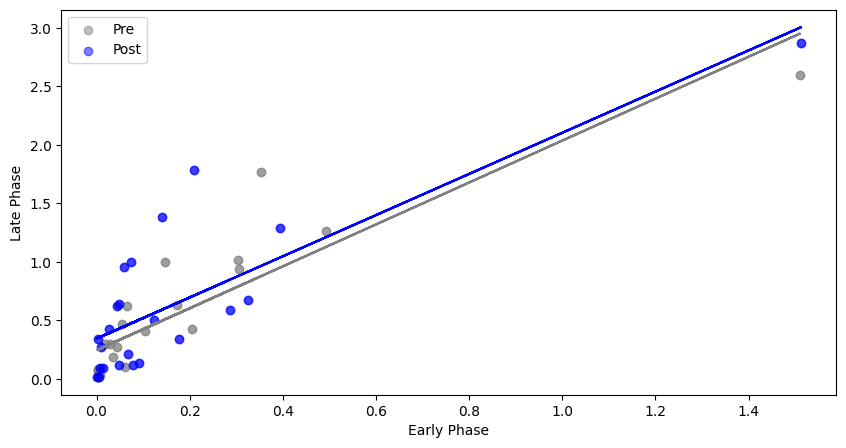

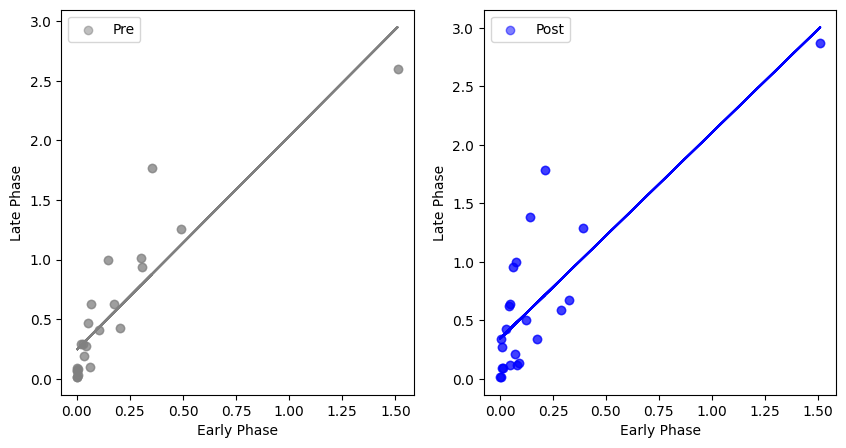

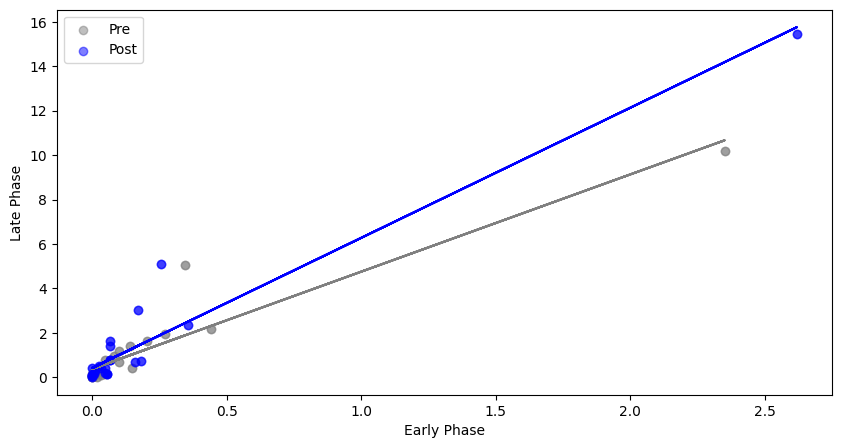

In [81]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

def plot_regression(data, stimulation='Pooled', overlay=True, log_scale=False):
    
    pre_early = []
    pre_late = []
    post_early = []
    post_late = []

    for group in data.values():
        for epoch_data in group.values():
            for record in epoch_data:
                pre_early.append(record[f'Pre_{stimulation}_early'])
                pre_late.append(record[f'Pre_{stimulation}_late'])
                post_early.append(record[f'Post_{stimulation}_early'])
                post_late.append(record[f'Post_{stimulation}_late'])

    fig, ax = plt.subplots(1, 2 if not overlay else 1, figsize=(10, 5))

    if log_scale:
        pre_early = [np.log(x+1) for x in pre_early]
        pre_late = [np.log(x+1) for x in pre_late]
        post_early = [np.log(x+1) for x in post_early]
        post_late = [np.log(x+1) for x in post_late]

    if overlay:
        ax.scatter(pre_early, pre_late, color='grey', alpha=0.5, label='Pre')
        ax.scatter(post_early, post_late, color='blue', alpha=0.5, label='Post')
        
        # Adding simple linear regression lines
        slope, intercept, _, _, _ = stats.linregress(pre_early, pre_late)
        ax.plot(pre_early, np.array(pre_early)*slope + intercept, color='grey')
        
        slope, intercept, _, _, _ = stats.linregress(post_early, post_late)
        ax.plot(post_early, np.array(post_early)*slope + intercept, color='blue')
        
        ax.set_xlabel('Early Phase')
        ax.set_ylabel('Late Phase')
    else:
        ax[0].scatter(pre_early, pre_late, color='grey', alpha=0.5, label='Pre')
        ax[1].scatter(post_early, post_late, color='blue', alpha=0.5, label='Post')
        
        # Adding simple linear regression lines
        slope, intercept, _, _, _ = stats.linregress(pre_early, pre_late)
        ax[0].plot(pre_early, np.array(pre_early)*slope + intercept, color='grey')
        
        slope, intercept, _, _, _ = stats.linregress(post_early, post_late)
        ax[1].plot(post_early, np.array(post_early)*slope + intercept, color='blue')
        
        ax[0].set_xlabel('Early Phase')
        ax[0].set_ylabel('Late Phase')
        ax[1].set_xlabel('Early Phase')
        ax[1].set_ylabel('Late Phase')
        
        ax[0].legend()

    plt.legend()
    plt.show()

# Example commands to test the function
# Replace 'test' with your actual data dictionary
plot_regression(test, stimulation='Pooled', overlay=True, log_scale=True)
plot_regression(test, stimulation='Pooled', overlay=False, log_scale=True)
plot_regression(test, stimulation='Low', overlay=True, log_scale=False)


In [82]:
print(type(test['Lmc_opsin']['Pre'])) #prints the type of the data
print(len(test['Lmc_opsin']['Pre'])) #print the number of units in the pre epoch of the Lmc_opsin group
print(test['Lmc_opsin']['Pre'][0].keys()) #print the keys of the first element in the list 

<class 'list'>
14
dict_keys(['Recording', 'CellID', 'Pre_Zero_early', 'Pre_Zero_late', 'Pre_Low_early', 'Pre_Low_late', 'Pre_Mid_early', 'Pre_Mid_late', 'Pre_Max_early', 'Pre_Max_late', 'Pre_Pooled_early', 'Pre_Pooled_late', 'Post_Zero_early', 'Post_Zero_late', 'Post_Low_early', 'Post_Low_late', 'Post_Mid_early', 'Post_Mid_late', 'Post_Max_early', 'Post_Max_late', 'Post_Pooled_early', 'Post_Pooled_late'])


In [83]:
print(type(test['Lmc_opsin']['Pre'])) #prints the type of the data
print(len(test['Lmc_opsin']['Pre'])) #print the number of units in the pre epoch of the Lmc_opsin group
print(test['Lmc_opsin']['Pre'][0].keys()) #print the keys of the first element in the list 

<class 'list'>
14
dict_keys(['Recording', 'CellID', 'Pre_Zero_early', 'Pre_Zero_late', 'Pre_Low_early', 'Pre_Low_late', 'Pre_Mid_early', 'Pre_Mid_late', 'Pre_Max_early', 'Pre_Max_late', 'Pre_Pooled_early', 'Pre_Pooled_late', 'Post_Zero_early', 'Post_Zero_late', 'Post_Low_early', 'Post_Low_late', 'Post_Mid_early', 'Post_Mid_late', 'Post_Max_early', 'Post_Max_late', 'Post_Pooled_early', 'Post_Pooled_late'])


In [ ]:
from scipy import stats
import numpy as np

def calculate_pearson_correlations(EED, group_name=None):
    """
    Calculate the Pearson correlation coefficients using the individual trial responses from both the early and late windows during both the pre and post epochs for each unit.

    Parameters:
    EED (object): The object containing the electrophysiology data.
    group_name (str, optional): The name of the group to analyze. Defaults to None, in which case all groups are analyzed.

    Returns:
    dict: A dictionary containing the Pearson correlation coefficients for each unit.
    """
    
    # Get list of group names
    group_names = [group_name] if group_name else EED.group_names
    
    # Dictionary to store the Pearson correlation coefficients for each group
    pearson_correlations = {}
    
    # Loop through each group
    for group in group_names:
        recording_names = EED.get_recording_names(group)
        
        # Dictionary to store the Pearson correlation coefficients for all units in the current group
        group_pearson_correlations = {'Pre': [], 'Post': []}
        
        # Loop through each recording
        for recording in recording_names:
            cellid_names = EED.get_cellid_names(group, recording)
            
            # Loop through each cell ID
            for cell_id in cellid_names:
                # Get the pre and post stim data
                data = EED.get_pre_post_data(group, recording, cell_id)
                
                # Define stimulation levels and pooled stimulation levels
                stim_levels = ['Zero', 'Low', 'Mid', 'Max', 'Pooled']
                
                # Dictionary to store the Pearson correlation coefficients for the current unit
                unit_pearson_correlations = {'Recording': recording, 'CellID': cell_id}
                
                # Loop through each epoch (pre and post) and stimulation level to calculate Pearson correlation coefficients
                for epoch in ['Pre', 'Post']: #loop through the pre and post epochs
                    for stim_level in stim_levels: #loop through the stim levels
                        if stim_level == 'Pooled': #if the stim level is pooled, then use all stim levels
                            stim_indices = [1, 2, 3] #indices for the stim levels
                        else: #otherwise, use the stim level specified
                            stim_indices = [stim_levels.index(stim_level)] #create a list with the index of the stim level
                        
                        # Get spike trains for the current stimulation level
                        spiketrains = np.concatenate([data[epoch]['SpikeTrains_for_PSTHs'][i] for i in stim_indices], axis=0) #list comprehension to get the spike trains for the stim level by looping through the stim indices
                        
                        # Extract spike data for the early phase (0-50 ms post-stimulus)
                        early_phase = spiketrains[:, 500:550]  # Adjust indices as necessary
                        
                        # Extract spike data for the late phase (100-700 ms post-stimulus)
                        late_phase = spiketrains[:, 600:1200]  # Adjust indices as necessary
                        
                        # Calculate the total number of spikes in each trial during the early and late phases
                        early_response = early_phase.sum(axis=1) #sum across the rows which are the trials for the early phase
                        late_response = late_phase.sum(axis=1) #sum across the rows which are the trials for the late phase
                        
                        # Calculate the Pearson correlation coefficient for the early and late responses
                        corr, _ = stats.pearsonr(early_response, late_response)
                        
                        # Add the Pearson correlation coefficient to the dictionary
                        unit_pearson_correlations[f'{epoch}_{stim_level}_Pearson_Correlation'] = corr
                
                # Calculate the difference between post and pre Pearson correlation coefficients for each stimulation level
                for stim_level in stim_levels:
                    pre_corr = unit_pearson_correlations[f'Pre_{stim_level}_Pearson_Correlation']
                    post_corr = unit_pearson_correlations[f'Post_{stim_level}_Pearson_Correlation']
                    unit_pearson_correlations[f'{stim_level}_Correlation_Difference'] = post_corr - pre_corr
                
                # Add the Pearson correlation coefficients for the current unit to the list
                group_pearson_correlations['Pre'].append(unit_pearson_correlations)
                group_pearson_correlations['Post'].append(unit_pearson_correlations)
        
        # Add the Pearson correlation coefficients for the current group to the dictionary
        pearson_correlations[group] = group_pearson_correlations
    
    return pearson_correlations


# use the function
pearson_correlations = calculate_pearson_correlations(EED, group_name=None)

In [ ]:
pearson_correlations.keys() #prints the keys of the dictionary
pearson_correlations['Lmc_opsin'].keys() 
pearson_correlations['Lmc_opsin']['Pre'][0]

In [ ]:
print(list(pearson_correlations.values())[0].keys())

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def plot_correlation_differences(correlation_data, stimulation_level):
    """
    Plot the correlation differences for all units, ranked from least to most, for a specified stimulation level.

    Parameters:
    correlation_data (dict): The dictionary containing the Pearson correlation data for each unit.
    stimulation_level (str): The stimulation level to plot (one of 'Zero', 'Low', 'Mid', 'Max', 'Pooled').

    Returns:
    None: The function will plot the data but not return any values.
    """
    
    # Loop through each group in the correlation data
    for group_name, group_data in correlation_data.items():
        
        # List to store all units and their correlation differences
        all_units_correlation_differences = []

        # Loop through each unit in the 'Pre' epoch to get its correlation difference for the specified stimulation level
        for unit in group_data['Pre']:
            # Get the correlation difference for the current unit and the specified stimulation level
            correlation_difference = unit.get(f'{stimulation_level}_Correlation_Difference') # Returns None if the key doesn't exist
            
            # Skip units with invalid correlation differences
            if correlation_difference is None or np.isnan(correlation_difference):
                continue
            
            # Get the cell ID for the current unit
            cell_id = unit['CellID']
            
            # Add the unit's cell ID and correlation difference to the list
            all_units_correlation_differences.append((cell_id, correlation_difference))
        
        # Print the list of units and their correlation differences
        print(all_units_correlation_differences)  

        # Sort the units by their correlation differences from least to most
        sorted_units = sorted(all_units_correlation_differences, key=lambda x: x[1])
        
        # Get the cell IDs and correlation differences as separate lists
        cell_ids, correlation_differences = zip(*sorted_units)
        
        # Create a bar plot of the correlation differences
        plt.figure(figsize=(10, 6))
        
        # Create a colormap for the bar colors
        norm = mcolors.Normalize(vmin=-1, vmax=1)
        cmap = plt.cm.get_cmap('coolwarm')
        
        # Create a bar plot with colors based on the correlation differences
        plt.bar(range(len(correlation_differences)), correlation_differences, tick_label=cell_ids, color=cmap(norm(correlation_differences)))
        
        # Add a colorbar to the plot
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, label='Correlation Difference')
        
        # Add labels and title to the plot
        plt.xlabel('Cell ID')
        plt.ylabel('Correlation Difference')
        plt.title(f'Correlation Differences for {stimulation_level} Stimulation in {group_name} group')
        
        # Rotate the x-axis labels for better readability
        plt.xticks(rotation=90)
        
        # Display the plot
        plt.show()



plot_correlation_differences(pearson_correlations, 'Mid')

#loop over the stimulation levels
for stimulation_level in ['Zero', 'Low', 'Mid', 'Max', 'Pooled']:
    plot_correlation_differences(pearson_correlations, stimulation_level)


In [ ]:
from scipy import stats
import numpy as np

def calculate_global_pearson_correlations(EED, group_name=None):
    """
    Calculate the Pearson correlation coefficients using the mean responses from both the early and late windows during both the pre and post epochs for each unit.

    Parameters:
    EED (object): The object containing the electrophysiology data.
    group_name (str, optional): The name of the group to analyze. Defaults to None, in which case all groups are analyzed.

    Returns:
    dict: A dictionary containing the Pearson correlation coefficients for each unit.
    """
    
    group_names = [group_name] if group_name else EED.group_names
    
    detailed_data = {}
    
    for group in group_names:
        recording_names = EED.get_recording_names(group)
        
        for recording in recording_names:
            cellid_names = EED.get_cellid_names(group, recording)
            
            for cell_id in cellid_names:
                data = EED.get_pre_post_data(group, recording, cell_id)
                
                stim_levels = ['Zero', 'Low', 'Mid', 'Max', 'Pooled']
                
                for epoch in ['Pre', 'Post']:
                    for stim_level in stim_levels:
                        if stim_level == 'Pooled':
                            stim_indices = [1, 2, 3]
                        else:
                            stim_indices = [stim_levels.index(stim_level)]
                        
                        spiketrains = np.concatenate([data[epoch]['SpikeTrains_for_PSTHs'][i] for i in stim_indices], axis=0)
                        
                        early_phase = spiketrains[:, 500:550]
                        late_phase = spiketrains[:, 600:1200]
                        
                        early_response = early_phase.sum(axis=1) / early_phase.shape[1]
                        late_response = late_phase.sum(axis=1) / late_phase.shape[1]
                        
                        early_mean = early_response.mean()
                        late_mean = late_response.mean()
                        
                        detailed_data.setdefault(group, {}).setdefault(recording, {}).setdefault(cell_id, {}).setdefault(epoch, {}).setdefault(stim_level, {
                            'early_phase': early_phase,
                            'late_phase': late_phase,
                            'early_response': early_response,
                            'late_response': late_response,
                            'early_mean': early_mean,
                            'late_mean': late_mean
                        })
    
    return detailed_data

# use the function
# detailed_data = calculate_global_pearson_correlations(EED, group_name=None)


# use the function
pearson_correlations_global = calculate_global_pearson_correlations(EED, group_name=None)


In [ ]:
pearson_correlations_global.keys() #prints the keys of the dictionary

In [ ]:
from scipy import stats

def calculate_pearson_correlations(EED, detailed_data):
    """
    Calculate the Pearson correlation coefficients using the mean responses from the detailed data.

    Parameters:
    EED (object): The object containing the electrophysiology data.
    detailed_data (dict): The dictionary containing the detailed data including early and late mean responses.

    Returns:
    dict: A dictionary containing the Pearson correlation coefficients for each stimulation level and epoch.
    dict: A dictionary containing the cell IDs that were removed due to NaN values.
    """

    pearson_correlations = {}
    removed_cell_ids = {}

    # Get list of group names
    group_names = EED.group_names

    # Define stimulation levels
    stim_levels = ['Zero', 'Low', 'Mid', 'Max', 'Pooled']

    # Loop through each group
    for group in group_names:
        group_correlations = {}

        # Loop through each epoch (pre and post) and stimulation level to calculate Pearson correlation coefficients
        for epoch in ['Pre', 'Post']: 
            for stim_level in stim_levels: 

                # Pool early and late means from all units for the current group, epoch, and stimulation level
                early_means = []
                late_means = []

                recording_names = EED.get_recording_names(group)
                for recording in recording_names:
                    cellid_names = EED.get_cellid_names(group, recording)
                    for cell_id in cellid_names:
                        early_mean = detailed_data[group][recording][cell_id][epoch][stim_level]['early_mean']
                        late_mean = detailed_data[group][recording][cell_id][epoch][stim_level]['late_mean']

                        if not np.isnan(early_mean) and not np.isnan(late_mean):
                            early_means.append(early_mean)
                            late_means.append(late_mean)
                        else:
                            removed_cell_ids.setdefault(group, {}).setdefault(recording, {}).setdefault(epoch, {}).setdefault(stim_level, []).append(cell_id)

                # Calculate the Pearson correlation coefficient
                if early_means and late_means:  # Ensure the lists are not empty
                    corr, _ = stats.pearsonr(early_means, late_means)
                else:
                    corr = None

                # Store the Pearson correlation coefficient in the dictionary
                group_correlations.setdefault(epoch, {}).setdefault(stim_level, corr)

        # Add the Pearson correlation coefficients for the current group to the dictionary
        pearson_correlations[group] = group_correlations

    return pearson_correlations, removed_cell_ids

# Use the function
pearson_correlations, removed_cell_ids = calculate_pearson_correlations(EED, pearson_correlations_global)


In [55]:
pearson_correlations['Lmc_opsin']

NameError: name 'pearson_correlations' is not defined

In [84]:
import numpy as np
import pandas as pd

def individual_unit_analysis(EED, group_name=None):
    """
    Perform a comprehensive individual unit analysis including descriptive statistics, 
    time series analysis, correlation analysis, visualization, response profiling, 
    and outlier identification.

    Parameters:
    EED (object): The object containing the electrophysiology data.
    group_name (str, optional): The name of the group to analyze. Defaults to None, in which case all groups are analyzed.

    Returns:
    dict: A dictionary containing the results of all the analyses for each unit.
    """
    
    # Get list of group names
    group_names = [group_name] if group_name else EED.group_names
    
    # Dictionary to store the analysis results for each group
    analysis_results = {}
    
    # Loop through each group
    for group in group_names:
        recording_names = EED.get_recording_names(group)
        
        # Dictionary to store the analysis results for all units in the current group
        group_analysis_results = {}
        
        # Loop through each recording
        for recording in recording_names:
            cellid_names = EED.get_cellid_names(group, recording)
            
            # Loop through each cell ID
            for cell_id in cellid_names:
                # Get the pre and post stim data
                data = EED.get_pre_post_data(group, recording, cell_id)
                
                # Define stimulation levels and pooled stimulation levels
                stim_levels = ['Zero', 'Low', 'Mid', 'Max', 'Pooled']
                
                # Dictionary to store the analysis results for the current unit
                unit_analysis_results = {'Recording': recording, 'CellID': cell_id}
                
                # Loop through each epoch (pre and post) and stimulation level to calculate descriptive statistics
                for epoch in ['Pre', 'Post']: #loop through the pre and post epochs
                    for stim_level in stim_levels: #loop through the stim levels
                        if stim_level == 'Pooled': #if the stim level is pooled, then use all stim levels
                            stim_indices = [1, 2, 3] #indices for the stim levels
                        else: #otherwise, use the stim level specified
                            stim_indices = [stim_levels.index(stim_level)] #create a list with the index of the stim level
                        
                        # Get spike trains for the current stimulation level
                        spiketrains = np.concatenate([data[epoch]['SpikeTrains_for_PSTHs'][i] for i in stim_indices], axis=0) #list comprehension to get the spike trains for the stim level by looping through the stim indices
                        
                        # Extract spike data for the early phase (0-50 ms post-stimulus)
                        early_phase = spiketrains[:, 500:550]  # Adjust indices as necessary
                        
                        # Extract spike data for the late phase (100-700 ms post-stimulus)
                        late_phase = spiketrains[:, 600:1200]  # Adjust indices as necessary
                        
                        # Calculate the total number of spikes in each trial during the early and late phases
                        early_response = early_phase.sum(axis=1) / early_phase.shape[0] # Normalize by the number of trials which is the number of rows
                        late_response = late_phase.sum(axis=1) / late_phase.shape[0] # Normalize by the number of trials which is the number of rows
                        
                        # Calculate descriptive statistics
                        early_mean = np.mean(early_response)
                        late_mean = np.mean(late_response)
                        early_median = np.median(early_response)
                        late_median = np.median(late_response)
                        early_std = np.std(early_response)
                        late_std = np.std(late_response) 
                        
                        # Calculate the mean of the standard deviations across trials
                        mean_std_early = np.mean(np.std(early_phase, axis=1))
                        mean_std_late = np.mean(np.std(late_phase, axis=1))
                        
                        # Step 2: Time Series Analysis
                        # Calculate the autocorrelation of the early and late responses
                        early_autocorr = np.correlate(early_response, early_response, mode='full')
                        late_autocorr = np.correlate(late_response, late_response, mode='full')
                        
                        # Step 3: Correlation Analysis
                        # Calculate the Pearson correlation coefficient between the early and late responses
                        corr, p_value = stats.pearsonr(early_response, late_response)

                        # Step 5: Creating Response Profiles
                        # Calculate the difference between the mean responses in the early and late phases
                        mean_response_difference = late_mean - early_mean
                        # Calculate the fold change relative to the early mean
                        fold_change = late_mean / early_mean if early_mean != 0 else np.nan
                        
 
                        # Store the data and descriptive statistics in the dictionary
                        unit_analysis_results[f'{epoch}_{stim_level}_early_phase'] = early_phase
                        unit_analysis_results[f'{epoch}_{stim_level}_late_phase'] = late_phase
                        unit_analysis_results[f'{epoch}_{stim_level}_early_response'] = early_response
                        unit_analysis_results[f'{epoch}_{stim_level}_late_response'] = late_response
                        unit_analysis_results[f'{epoch}_{stim_level}_early_mean'] = early_mean
                        unit_analysis_results[f'{epoch}_{stim_level}_late_mean'] = late_mean
                        unit_analysis_results[f'{epoch}_{stim_level}_early_median'] = early_median
                        unit_analysis_results[f'{epoch}_{stim_level}_late_median'] = late_median
                        unit_analysis_results[f'{epoch}_{stim_level}_early_std'] = early_std
                        unit_analysis_results[f'{epoch}_{stim_level}_late_std'] = late_std
                        unit_analysis_results[f'{epoch}_{stim_level}_mean_std_early'] = mean_std_early
                        unit_analysis_results[f'{epoch}_{stim_level}_mean_std_late'] = mean_std_late
                        
                        # Store the autocorrelation data in the dictionary
                        unit_analysis_results[f'{epoch}_{stim_level}_early_autocorr'] = early_autocorr
                        unit_analysis_results[f'{epoch}_{stim_level}_late_autocorr'] = late_autocorr
                        
                        # Store the Pearson correlation coefficient and the p-value in the dictionary
                        unit_analysis_results[f'{epoch}_{stim_level}_Pearson_Correlation'] = corr
                        unit_analysis_results[f'{epoch}_{stim_level}_P_value'] = p_value
                        
                        # Store the response profile metrics in the dictionary
                        unit_analysis_results[f'{epoch}_{stim_level}_mean_response_difference'] = mean_response_difference
                        unit_analysis_results[f'{epoch}_{stim_level}_fold_change'] = fold_change
                        
                # Add the analysis results for the current unit to the dictionary
                group_analysis_results[cell_id] = unit_analysis_results
        
        # Add the analysis results for the current group to the dictionary
        analysis_results[group] = group_analysis_results
        
    # Convert the nested dictionary to a pandas DataFrame for easy data manipulation and visualization
    analysis_results_df = pd.DataFrame.from_dict({(group_name, cell_id): analysis_results[group_name][cell_id] 
                                                  for group_name in analysis_results.keys() 
                                                  for cell_id in analysis_results[group_name].keys()},
                                                 orient='index')

    return  analysis_results, analysis_results_df




individual_unit_analysis_output, individual_unit_analysis_df_output = individual_unit_analysis(EED, group_name=None)



/Users/cresp1el/anaconda3/envs/matlab_python_proj/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



In [85]:
individual_unit_analysis_df_output 

Recording  CellID  \
Lmc_noopsin cid159  lmc_noch_1_3096_rec1  cid159   
            cid169  lmc_noch_1_3096_rec1  cid169   
            cid24   lmc_noch_1_3096_rec1   cid24   
            cid244  lmc_noch_1_3096_rec1  cid244   
            cid251  lmc_noch_1_3096_rec1  cid251   
            cid21   lmc_noch_1_3096_rec2   cid21   
            cid211  lmc_noch_1_3096_rec2  cid211   
            cid219  lmc_noch_1_3096_rec2  cid219   
            cid22   lmc_noch_1_3096_rec2   cid22   
Lmc_opsin   cid134    lmc_ch_1_3094_rec1  cid134   
            cid145    lmc_ch_1_3094_rec1  cid145   
            cid148    lmc_ch_1_3094_rec1  cid148   
            cid156    lmc_ch_1_3094_rec1  cid156   
            cid238    lmc_ch_1_3094_rec1  cid238   
            cid52     lmc_ch_1_3094_rec1   cid52   
            cid91     lmc_ch_1_3094_rec1   cid91   
            cid113    lmc_ch_1_3094_rec2  cid113   
            cid79     lmc_ch_1_3094_rec2   cid79   
            cid82     lmc_ch_1_3094_rec2   cid82   
            cid102    lmc_ch_2_3093_rec1  cid102   
            cid39     lmc_ch_2_3093_rec1   cid39   
            cid81     lmc_ch_2_3093_rec1   cid81   
            cid93     lmc_ch_2_3093_rec1   cid93   

                                                 Pre_Zero_early_phase  \
Lmc_noopsin cid159  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid169  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid24   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid244  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid251  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid21   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid211  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid219  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid22   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
Lmc_opsin   cid134  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid145  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid148  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid156  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid238  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid52   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid91   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid113  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid79   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid82   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid102  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid39   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid81   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid93   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                                  Pre_Zero_late_phase  \
Lmc_noopsin cid159  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid169  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid24   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid244  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid251  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid21   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid211  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid219  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid22   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
Lmc_opsin   cid134  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid145  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid148  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid156  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
       

In [ ]:
individual_unit_analysis_output['Lmc_opsin']['cid102']['Post_Low_early_autocorr']

#now plot this data individual_unit_analysis_output['Lmc_opsin']['cid102']['Post_Low_early_autocorr']
plt.plot(individual_unit_analysis_output['Lmc_opsin']['cid93']['Post_Low_early_autocorr'])

In [ ]:
individual_unit_analysis_output['Lmc_opsin']['cid102']['Post_Low_Pearson_Correlation']
#now look at mid 
individual_unit_analysis_output['Lmc_opsin']['cid102']['Post_Mid_Pearson_Correlation']
#now look at max
individual_unit_analysis_output['Lmc_opsin']['cid102']['Post_Max_Pearson_Correlation'] 
#now look at zero
individual_unit_analysis_output['Lmc_opsin']['cid102']['Post_Zero_Pearson_Correlation']

#repeat this process for cid102 and print the pearson correlation coefficients for each stimulation level
print(individual_unit_analysis_output['Lmc_opsin']['cid102']['Post_Zero_Pearson_Correlation'])
print(individual_unit_analysis_output['Lmc_opsin']['cid102']['Post_Low_Pearson_Correlation'])
print(individual_unit_analysis_output['Lmc_opsin']['cid102']['Post_Mid_Pearson_Correlation'])
print(individual_unit_analysis_output['Lmc_opsin']['cid102']['Post_Max_Pearson_Correlation'])

#now print the mean for cid 102 for each stimulation level 
print(individual_unit_analysis_output['Lmc_opsin']['cid102']['Post_Zero_late_mean'])
print(individual_unit_analysis_output['Lmc_opsin']['cid102']['Post_Low_late_mean'])
print(individual_unit_analysis_output['Lmc_opsin']['cid102']['Post_Mid_late_mean'])
print(individual_unit_analysis_output['Lmc_opsin']['cid102']['Post_Max_late_mean'])



In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.colors as mcolors

import plotly.graph_objects as go

class NeuralDataAnalysis:
    def __init__(self, EED, group_name=None):
        self.EED = EED
        self.group_name = group_name
        self.analysis_results = None
        self.analysis_df = None

    def individual_unit_analysis(self):
        """
        Perform a comprehensive individual unit analysis including descriptive statistics, 
        time series analysis, correlation analysis, visualization, response profiling, 
        and outlier identification.

        Parameters:
        EED (object): The object containing the electrophysiology data.
        group_name (str, optional): The name of the group to analyze. Defaults to None, in which case all groups are analyzed.

        Returns:
        dict: A dictionary containing the results of all the analyses for each unit.
        """
        
        # Get list of group names
        group_names = [self.group_name] if self.group_name else self.EED.group_names
        
        # Dictionary to store the analysis results for each group
        analysis_results = {}
        
        # Loop through each group
        for group in group_names:
            recording_names = EED.get_recording_names(group)
            
            # Dictionary to store the analysis results for all units in the current group
            group_analysis_results = {}
            
            # Loop through each recording
            for recording in recording_names:
                cellid_names = EED.get_cellid_names(group, recording)
                
                # Loop through each cell ID
                for cell_id in cellid_names:
                    # Get the pre and post stim data
                    data = EED.get_pre_post_data(group, recording, cell_id)
                    
                    # Define stimulation levels and pooled stimulation levels
                    stim_levels = ['Zero', 'Low', 'Mid', 'Max', 'Pooled']
                    
                    # Dictionary to store the analysis results for the current unit
                    unit_analysis_results = {'Recording': recording, 'CellID': cell_id}
                    
                    # Loop through each epoch (pre and post) and stimulation level to calculate descriptive statistics
                    for epoch in ['Pre', 'Post']: #loop through the pre and post epochs
                        for stim_level in stim_levels: #loop through the stim levels
                            if stim_level == 'Pooled': #if the stim level is pooled, then use all stim levels
                                stim_indices = [1, 2, 3] #indices for the stim levels
                            else: #otherwise, use the stim level specified
                                stim_indices = [stim_levels.index(stim_level)] #create a list with the index of the stim level
                            
                            # Get spike trains for the current stimulation level
                            spiketrains = np.concatenate([data[epoch]['SpikeTrains_for_PSTHs'][i] for i in stim_indices], axis=0) #list comprehension to get the spike trains for the stim level by looping through the stim indices
                            
                            # Store the spike trains in the dictionary
                            unit_analysis_results[f'{epoch}_{stim_level}_spiketrains'] = spiketrains
                            
                            # Extract spike data for the early phase (0-50 ms post-stimulus)
                            early_phase = spiketrains[:, 500:550]  # Adjust indices as necessary
                            
                            # Extract spike data for the late phase (100-700 ms post-stimulus)
                            late_phase = spiketrains[:, 600:1200]  # Adjust indices as necessary
                            
                            # Calculate the total number of spikes in each trial during the early and late phases
                            early_response = early_phase.sum(axis=1) / early_phase.shape[0] # Normalize by the number of trials which is the number of rows
                            late_response = late_phase.sum(axis=1) / late_phase.shape[0] # Normalize by the number of trials which is the number of rows
                            
                            # Calculate descriptive statistics
                            early_mean = np.mean(early_response)
                            late_mean = np.mean(late_response)
                            early_median = np.median(early_response)
                            late_median = np.median(late_response)
                            early_std = np.std(early_response)
                            late_std = np.std(late_response) 
                            
                            # Calculate the mean of the standard deviations across trials
                            mean_std_early = np.mean(np.std(early_phase, axis=1))
                            mean_std_late = np.mean(np.std(late_phase, axis=1))
                            
                            # Step 2: Time Series Analysis
                            # Calculate the autocorrelation of the early and late responses
                            early_autocorr = np.correlate(early_response, early_response, mode='full')
                            late_autocorr = np.correlate(late_response, late_response, mode='full')
                            
                            # Step 3: Correlation Analysis
                            # Calculate the Pearson correlation coefficient between the early and late responses
                            corr, p_value = stats.pearsonr(early_response, late_response)

                            # Step 5: Creating Response Profiles
                            # Calculate the difference between the mean responses in the early and late phases
                            mean_response_difference = late_mean - early_mean
                            # Calculate the fold change relative to the early mean
                            fold_change = late_mean / early_mean if early_mean != 0 else np.nan
                            
    
                            # Store the data and descriptive statistics in the dictionary
                            unit_analysis_results[f'{epoch}_{stim_level}_early_phase'] = early_phase
                            unit_analysis_results[f'{epoch}_{stim_level}_late_phase'] = late_phase
                            unit_analysis_results[f'{epoch}_{stim_level}_early_response'] = early_response
                            unit_analysis_results[f'{epoch}_{stim_level}_late_response'] = late_response
                            unit_analysis_results[f'{epoch}_{stim_level}_early_mean'] = early_mean
                            unit_analysis_results[f'{epoch}_{stim_level}_late_mean'] = late_mean
                            unit_analysis_results[f'{epoch}_{stim_level}_early_median'] = early_median
                            unit_analysis_results[f'{epoch}_{stim_level}_late_median'] = late_median
                            unit_analysis_results[f'{epoch}_{stim_level}_early_std'] = early_std
                            unit_analysis_results[f'{epoch}_{stim_level}_late_std'] = late_std
                            unit_analysis_results[f'{epoch}_{stim_level}_mean_std_early'] = mean_std_early
                            unit_analysis_results[f'{epoch}_{stim_level}_mean_std_late'] = mean_std_late
                            
                            # Store the autocorrelation data in the dictionary
                            unit_analysis_results[f'{epoch}_{stim_level}_early_autocorr'] = early_autocorr
                            unit_analysis_results[f'{epoch}_{stim_level}_late_autocorr'] = late_autocorr
                            
                            # Store the Pearson correlation coefficient and the p-value in the dictionary
                            unit_analysis_results[f'{epoch}_{stim_level}_Pearson_Correlation'] = corr
                            unit_analysis_results[f'{epoch}_{stim_level}_P_value'] = p_value
                            
                            # Store the response profile metrics in the dictionary
                            unit_analysis_results[f'{epoch}_{stim_level}_mean_response_difference'] = mean_response_difference
                            unit_analysis_results[f'{epoch}_{stim_level}_fold_change'] = fold_change
                            
                    # Add the analysis results for the current unit to the dictionary
                    group_analysis_results[cell_id] = unit_analysis_results
            
            # Add the analysis results for the current group to the dictionary
            analysis_results[group] = group_analysis_results
            
        # Convert the nested dictionary to a pandas DataFrame for easy data manipulation and visualization
        analysis_results_df = pd.DataFrame.from_dict({(group_name, cell_id): analysis_results[group_name][cell_id] 
                                                    for group_name in analysis_results.keys() 
                                                    for cell_id in analysis_results[group_name].keys()},
                                                    orient='index')


        # Set the analysis_results attribute with the results dictionary
        self.analysis_results = analysis_results
        self.analysis_df = analysis_results_df
        
        # Return the DataFrame for inspection
        return analysis_results_df, analysis_results

    def rank_units_by_metric(self, group_name, column_name, ascending=True):
        """
        Rank units within a specified group based on a specified metric (e.g., Pearson correlation, fold change).

        Parameters:
        group_name (str): The name of the group to rank the units for.
        column_name (str): The name of the column (metric) to base the rankings on.
        ascending (bool): Whether to rank in ascending order. Defaults to True.

        Returns:
        pd.DataFrame: A DataFrame containing the unit IDs and their respective rankings.
        """
        
        
        group_data = self.analysis_df.loc[group_name].copy()
        
        # Rank the units based on the specified column
        group_data['Rank'] = group_data[column_name].rank(ascending=ascending)
        
        # Get a DataFrame with only the Cell IDs and their rankings
        ranking_df = group_data[['CellID', 'Rank']]
        
        return ranking_df 



    def plot_ranked_units(self, group_name, column_name, ascending=True):
        """
        Plot the ranked units within a specified group based on a specified metric (e.g., Pearson correlation, fold change).

        Parameters:
        group_name (str): The name of the group to rank the units for.
        column_name (str): The name of the column (metric) to base the rankings on.
        ascending (bool): Whether to rank in ascending order. Defaults to True.

        Returns:
        None: The function will plot the data but not return any values.
        """
        
        # Get the ranking data
        ranking_df = self.rank_units_by_metric(group_name, column_name, ascending)
        
        # Get the data to plot
        group_data = self.analysis_df.loc[group_name]
        
        # Merge the ranking data with the group data to get the values for the specified column
        plot_data = group_data.merge(ranking_df, on='CellID')
        
        # Sort the data based on the rank
        plot_data.sort_values(by='Rank', inplace=True)
        
        # Get a colormap
        cmap = plt.get_cmap('viridis')
        
        # Get the range of data values to set the color range
        data_min = plot_data[column_name].min()
        data_max = plot_data[column_name].max()
        
        # Create a normalized color range based on the data values
        norm = mcolors.Normalize(vmin=data_min, vmax=data_max)
        
        # Get a list of colors based on the normalized data values
        colors = cmap(norm(plot_data[column_name].values))
        
        # Plot the data with the colors
        plt.figure(figsize=(10, 6))
        plt.bar(plot_data['CellID'], plot_data[column_name], color=colors)
        
        # Set labels, title, etc.
        plt.xlabel('Cell ID')
        plt.ylabel(column_name)
        plt.title(f'Ranking of Units in {group_name} based on {column_name}')
        plt.xticks(rotation=90)
        plt.grid(axis='y')
        
        # Add a colorbar to show the color mapping
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        plt.colorbar(sm)
        
        plt.show()
        
    def plot_mean_firing(self, stim_level, group_name=None):
        """
        This method plots the mean firing rates for individual units and the grand mean across units 
        during the early and late phases of the pre and post epochs. The early and late mean firing 
        rates are represented by lines connecting empty and filled circles, respectively. The grand 
        mean is represented by a red line.

        Parameters:
        stim_level (str): The stimulation level to consider ('Zero', 'Low', 'Mid', 'Max', or 'Pooled').
        group_name (str, optional): The name of the group to plot data for. If None, data for all groups are plotted.

        Returns:
        None: The method displays the plot but does not return any values.
        """
        
        # Ensure the analysis results DataFrame is available
        if self.analysis_df is None:
            print("Please run the individual_unit_analysis method first.")
            return

        # Get the list of group names
        group_names = [group_name] if group_name else self.EED.group_names
        
        # Create a 1x2 subplot with shared y-axis
        fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

        # Loop through each group
        for group in group_names:
            
            # Loop through each epoch (Pre and Post) to create the plots
            for i, epoch in enumerate(['Pre', 'Post']):
                early_means = self.analysis_df.loc[group, f'{epoch}_{stim_level}_early_mean']
                late_means = self.analysis_df.loc[group, f'{epoch}_{stim_level}_late_mean']
                
                unit_ids = self.analysis_df.loc[group].index.get_level_values(0).unique()
                
                # Lists to store the early and late means for all units
                early_means_list = []
                late_means_list = []
                
                # Loop through each unit to gather the early and late means
                for unit_id in unit_ids:
                    early_mean = early_means.loc[unit_id]
                    late_mean = late_means.loc[unit_id]
                    
                    early_means_list.append(early_mean)
                    late_means_list.append(late_mean)
                
                # Now you have lists of early and late means for all units, and you can plot lines connecting these values
                for j, unit_id in enumerate(unit_ids):
                    color = 'grey' if epoch == 'Pre' else 'blue'
                    axes[i].plot([1, 2], [early_means_list[j], late_means_list[j]], marker='o', markersize=5, markerfacecolor=color, markeredgecolor=color, linestyle='-', color=color)
                    axes[i].plot(1, early_means_list[j], marker='o', markersize=5, markerfacecolor='white', markeredgecolor=color, linestyle='-', color=color)
                
                # Calculate the grand mean for all units
                grand_mean_early = np.mean(early_means_list)
                grand_mean_late = np.mean(late_means_list)
                
                # Plot the grand mean
                axes[i].plot([1, 2], [grand_mean_early, grand_mean_late], marker='o', markersize=7, markerfacecolor='none', color='red', linewidth=2, label='Grand Mean')
                
                # Set the x-ticks labels and title
                axes[i].set_xticks([1, 2])
                axes[i].set_xticklabels(['Early-Phase', 'Late-Phase'])
                axes[i].set_title(f'{epoch} Epoch with {stim_level} Stimulation')
                axes[i].set_xlabel('Phase')
                axes[i].set_ylabel('Mean Firing Rate')
            
            # Display a legend in the second plot
            axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
            
            # Adjust the layout to prevent overlapping
            plt.tight_layout()
            
            # Display the plot
            plt.show()
            
    def plot_standard_deviation(self, stim_level, group_name=None):
        """
        This method plots the standard deviation of firing rates for individual units and the grand mean across units 
        during the early and late phases of the pre and post epochs. The early and late standard deviations 
        are represented by lines connecting empty and filled circles, respectively. The grand mean is represented 
        by a red line for the pre epoch and a green line for the post epoch.

        Parameters:
        stim_level (str): The stimulation level to consider ('Zero', 'Low', 'Mid', 'Max', or 'Pooled').
        group_name (str, optional): The name of the group to plot data for. If None, data for all groups are plotted.

        Returns:
        None: The method displays the plot but does not return any values.
        """
        
        # Ensure the analysis results DataFrame is available
        if self.analysis_df is None:
            print("Please run the individual_unit_analysis method first.")
            return

        # Get the list of group names
        group_names = [group_name] if group_name else self.EED.group_names
        
        # Create a 1x2 subplot with shared y-axis
        fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
        
        # Loop through each group
        for group in group_names:
            
            # Loop through each epoch (Pre and Post) to create the plots
            for i, epoch in enumerate(['Pre', 'Post']):
                early_stds = self.analysis_df.loc[group, f'{epoch}_{stim_level}_early_std']
                late_stds = self.analysis_df.loc[group, f'{epoch}_{stim_level}_late_std']
                
                unit_ids = self.analysis_df.loc[group].index.get_level_values(0).unique()
                
                # Lists to store the early and late standard deviations for all units
                early_stds_list = []
                late_stds_list = []
                
                # Loop through each unit to gather the early and late standard deviations
                for unit_id in unit_ids:
                    early_std = early_stds.loc[unit_id]
                    late_std = late_stds.loc[unit_id]
                    
                    early_stds_list.append(early_std)
                    late_stds_list.append(late_std)
                
                # Now you have lists of early and late standard deviations for all units, and you can plot lines connecting these values
                for j, unit_id in enumerate(unit_ids):
                    color = 'grey' if epoch == 'Pre' else 'blue'
                    axes[i].plot([1, 2], [early_stds_list[j], late_stds_list[j]], marker='o', markersize=5, markerfacecolor=color, markeredgecolor=color, linestyle='-', color=color)
                    axes[i].plot(1, early_stds_list[j], marker='o', markersize=5, markerfacecolor='white', markeredgecolor=color, linestyle='-', color=color)
                    

                
                # Calculate the grand mean for all units
                grand_mean_early = np.mean(early_stds_list)
                grand_mean_late = np.mean(late_stds_list)
                
                # Plot the grand mean
                axes[i].plot([1, 2], [grand_mean_early, grand_mean_late], marker='o', markersize=7, markerfacecolor='none', color='red', linewidth=2, label='Grand Mean')
                
                # Set the x-ticks labels and title
                # And update the x-ticks and labels as follows:
                axes[i].set_xticks([1, 2])
                axes[i].set_xticklabels(['Early-Phase', 'Late-Phase'])
                axes[i].set_title(f'{epoch} Epoch with {stim_level} Stimulation')
                axes[i].set_xlabel('Phase')
                axes[i].set_ylabel('Standard Deviation of Firing Rate')
            
            # Display a legend in the second plot
            axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
            
            # Adjust the layout to prevent overlapping
            plt.tight_layout()
            
            # Display the plot
            plt.show()
    def plot_fold_change(self, stim_level, group_name=None):
        """
        This method plots the fold change of firing rates for individual units and the grand mean across units 
        during the early and late phases of the pre and post epochs. The fold changes 
        are represented by lines connecting circles, with the baseline represented as 1. The grand mean is represented 
        by a red line.

        Parameters:
        stim_level (str): The stimulation level to consider ('Zero', 'Low', 'Mid', 'Max', or 'Pooled').
        group_name (str, optional): The name of the group to plot data for. If None, data for all groups are plotted.

        Returns:
        None: The method displays the plot but does not return any values.
        """
        
        # Ensure the analysis results DataFrame is available
        if self.analysis_df is None:
            print("Please run the individual_unit_analysis method first.")
            return

        # Get the list of group names
        group_names = [group_name] if group_name else self.EED.group_names
        
        # Create a 1x2 subplot with shared y-axis
        fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
        
        # Loop through each group
        for group in group_names:
            
            # Loop through each epoch (Pre and Post) to create the plots
            for i, epoch in enumerate(['Pre', 'Post']):
                
                fold_changes = self.analysis_df.loc[group, f'{epoch}_{stim_level}_fold_change']
                unit_ids = self.analysis_df.loc[group].index.get_level_values(0).unique()
                
                # Lists to store the fold changes for all units
                fold_changes_list = []
                
                # Loop through each unit to gather the fold changes
                for unit_id in unit_ids:
                    fold_change = fold_changes.loc[unit_id]
                    fold_changes_list.append(fold_change)
                
                # Now you have a list of fold changes for all units, and you can plot lines connecting these values
                for j, unit_id in enumerate(unit_ids):
                    color = 'grey' if epoch == 'Pre' else 'blue'
                    axes[i].plot([1, 2], [1, fold_changes_list[j]], marker='o', markersize=5, markerfacecolor=color, markeredgecolor=color, linestyle='-', color=color)
                    
                # Calculate the grand mean for all units
                grand_mean_baseline = 1  # The baseline is 1 for fold change
                grand_mean_fold_change = np.mean(fold_changes_list)
                
                # Plot the grand mean
                axes[i].plot([1, 2], [grand_mean_baseline, grand_mean_fold_change], marker='o', markersize=7, markerfacecolor='none', color='red', linewidth=2, label='Grand Mean')
                
                # Set the x-ticks labels and title
                axes[i].set_xticks([1, 2])
                axes[i].set_xticklabels(['Baseline', 'Fold Change'])
                axes[i].set_title(f'{epoch} Epoch with {stim_level} Stimulation')
                axes[i].set_xlabel('Phase')
                axes[i].set_ylabel('Fold Change of Firing Rate')
            
            # Display a legend in the second plot
            axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
            
            # Adjust the layout to prevent overlapping
            plt.tight_layout()
            
            # Display the plot
            plt.show()
            
    def plot_fold_change_plotly(self, stim_level, group_name=None):
        """
        This method plots the fold change of firing rates for individual units and the grand mean across units 
        during the baseline and fold change phases of the pre and post epochs using Plotly for interactive visualization. 
        The baseline and fold change values are represented by lines connecting markers at x=1 and x=2, respectively. 
        The grand mean is represented by a red line for the pre epoch and a green line for the post epoch.

        Parameters:
        stim_level (str): The stimulation level to consider ('Zero', 'Low', 'Mid', 'Max', or 'Pooled').
        group_name (str, optional): The name of the group to plot data for. If None, data for all groups are plotted.

        Returns:
        None: The method displays the plot but does not return any values.
        """
        
        # Ensure the analysis results DataFrame is available
        if self.analysis_df is None:
            print("Please run the individual_unit_analysis method first.")
            return

        # Get the list of group names
        group_names = [group_name] if group_name else self.EED.group_names
        
        # Loop through each group
        for group in group_names:
            
            # Create a Plotly figure
            fig = go.Figure()
            
            # Loop through each epoch (Pre and Post) to create the plots
            for i, epoch in enumerate(['Pre', 'Post']):
                fold_changes = self.analysis_df.loc[group, f'{epoch}_{stim_level}_fold_change']
                
                unit_ids = self.analysis_df.loc[group].index.get_level_values(0).unique()
                
                # Lists to store the baseline and fold change values for all units
                baseline_list = [1] * len(unit_ids)
                fold_changes_list = []
                
                # Loop through each unit to gather the baseline and fold change values
                for unit_id in unit_ids:
                    fold_change = fold_changes.loc[unit_id]
                    fold_changes_list.append(fold_change)
                
                # Now you have lists of baseline and fold change values for all units, and you can plot lines connecting these values
                for j, unit_id in enumerate(unit_ids):
                    color = 'grey' if epoch == 'Pre' else 'blue'
                    fig.add_trace(go.Scatter(x=[1, 2], y=[1, fold_changes_list[j]], mode='lines+markers', marker=dict(color=color), line=dict(color=color), name=f'{unit_id} {epoch}', hovertemplate=f'Unit ID: {unit_id}<br>Phase: '+'%{x}<br>Fold Change: '+'%{y}'))

                # Calculate the grand mean for all units
                grand_mean_baseline = np.nanmean(baseline_list)
                grand_mean_fold_change = np.nanmean(fold_changes_list)
                
                
                # Plot the grand mean
                color = 'red' if epoch == 'Pre' else 'green'
                fig.add_trace(go.Scatter(x=[1, 2], y=[grand_mean_baseline, grand_mean_fold_change], mode='lines+markers', marker=dict(color=color), line=dict(color=color, width=2), name=f'Grand Mean {epoch}'))
            
            # Set the x-ticks labels and title            
            fig.update_layout(
                xaxis=dict(tickvals=[1, 2], ticktext=['Baseline', 'Fold Change']),
                title=f'Fold Change with {stim_level} Stimulation for group {group}',
                xaxis_title='Phase',
                yaxis_title='Fold Change',
                template='plotly_white',  # Change the template here
                width=800,  # Set the width of the plot (in pixels)
                height=600,  # Set the height of the plot (in pixels)
            )
            # Get the total number of traces (2 grand means + number of units for pre and post)
            num_traces = len(fig.data)

            # Define the dropdown buttons with dynamic visibility lists
            buttons = [
                dict(
                    args=[{'visible': [True] * num_traces}],  # Show all traces (both pre and post)
                    label='Both',
                    method='update'
                ),
                dict(
                    args=[{'visible': [True if i < num_traces // 2 else False for i in range(num_traces)]}],  # Show only pre traces
                    label='Pre',
                    method='update'
                ),
                dict(
                    args=[{'visible': [False if i < num_traces // 2 else True for i in range(num_traces)]}],  # Show only post traces
                    label='Post',
                    method='update'
                )
            ]

            # Add the dropdown buttons to the figure
            fig.update_layout(
                updatemenus=[
                    dict(
                        x=1.15,
                        y=1.2,
                        xanchor='left',
                        yanchor='top',
                        buttons=buttons
                    )
                ]
            )
            # Display the plot
            fig.show()

    def plot_standard_deviation_plotly(self, stim_level, group_name=None, data_type='both'):
            # Ensure the analysis results DataFrame is available
            if self.analysis_df is None:
                print("Please run the individual_unit_analysis method first.")
                return

            # Get the list of group names
            group_names = [group_name] if group_name else self.EED.group_names
            
            # Loop through each group
            for group in group_names:
                
                # Create a Plotly figure
                fig = go.Figure()
                
                # Loop through each epoch (Pre and Post) to create the plots
                for i, epoch in enumerate(['Pre', 'Post']):
                    
                    # Get the standard deviations for the early and late phases
                    early_std_devs = self.analysis_df.loc[group, f'{epoch}_{stim_level}_early_std']
                    late_std_devs = self.analysis_df.loc[group, f'{epoch}_{stim_level}_late_std']
                    
                    unit_ids = self.analysis_df.loc[group].index.get_level_values(0).unique()
                    
                    # Loop through each unit to gather the standard deviation values for early and late phases
                    for unit_id in unit_ids:
                        early_std_dev = early_std_devs.loc[unit_id]
                        late_std_dev = late_std_devs.loc[unit_id]
                        
                        color = 'grey' if epoch == 'Pre' else 'blue'
                        fig.add_trace(go.Scatter(x=['Early', 'Late'], y=[early_std_dev, late_std_dev], mode='lines+markers', marker=dict(color=color), line=dict(color=color), name=f'{unit_id} {epoch}', hovertemplate=f'Unit ID: {unit_id}<br>Phase: '+'%{x}<br>Std Dev: '+'%{y}'))
                    
                    # Get the mean standard deviations across units for early and late phases
                    mean_early_std_dev = np.nanmean(early_std_devs)
                    mean_late_std_dev = np.nanmean(late_std_devs)

                    color = 'red' if epoch == 'Pre' else 'green'
                    fig.add_trace(go.Scatter(x=['Early', 'Late'], y=[mean_early_std_dev, mean_late_std_dev], mode='lines+markers', marker=dict(color=color), line=dict(color=color, width=2), name=f'Mean Std Dev {epoch}'))
            
            # Set the x-ticks labels and title            
            fig.update_layout(
                xaxis=dict(tickvals=[0, 1], ticktext=['Early', 'Late']),
                title=f'Standard Deviation with {stim_level} Stimulation for group {group}',
                xaxis_title='Phase',
                yaxis_title='Standard Deviation',
                template='plotly_white',
                width=800,
                height=600,
            )
            
            # Get the total number of traces (2 grand means + number of units for pre and post)
            num_traces = len(fig.data)

            # Define the dropdown buttons with dynamic visibility lists
            buttons = [
                dict(
                    args=[{'visible': [True] * num_traces}],  # Show all traces (both pre and post)
                    label='Both',
                    method='update'
                ),
                dict(
                    args=[{'visible': [True if i < num_traces // 2 else False for i in range(num_traces)]}],  # Show only pre traces
                    label='Pre',
                    method='update'
                ),
                dict(
                    args=[{'visible': [False if i < num_traces // 2 else True for i in range(num_traces)]}],  # Show only post traces
                    label='Post',
                    method='update'
                )
            ]

            # Add the dropdown buttons to the figure
            fig.update_layout(
                updatemenus=[           
                    dict(
                        x=1.15,
                        y=1.2,
                        xanchor='left',
                        yanchor='top',
                        buttons=buttons
                    )
                ]
            )
            
            # Display the plot
            fig.show()
            
            
    def plot_mean_firing_rate_plotly(self, stim_level, group_name=None):
        # Ensure the analysis results DataFrame is available
        if self.analysis_df is None:
            print("Please run the individual_unit_analysis method first.")
            return

        # Get the list of group names
        group_names = [group_name] if group_name else self.EED.group_names
        
        # Loop through each group
        for group in group_names:
            
            # Create a Plotly figure
            fig = go.Figure()
            
            # Loop through each epoch (Pre and Post) to create the plots
            for i, epoch in enumerate(['Pre', 'Post']):
                
                # Get the mean firing rates for the early and late phases
                early_mean_rates = self.analysis_df.loc[group, f'{epoch}_{stim_level}_early_mean']
                late_mean_rates = self.analysis_df.loc[group, f'{epoch}_{stim_level}_late_mean']
                
                unit_ids = self.analysis_df.loc[group].index.get_level_values(0).unique()
                
                # Loop through each unit to gather the mean firing rates for early and late phases
                for unit_id in unit_ids:
                    early_mean_rate = early_mean_rates.loc[unit_id]
                    late_mean_rate = late_mean_rates.loc[unit_id]
                    
                    color = 'grey' if epoch == 'Pre' else 'blue'
                    fig.add_trace(go.Scatter(x=['Early', 'Late'], y=[early_mean_rate, late_mean_rate], mode='lines+markers', marker=dict(color=color), line=dict(color=color), name=f'{unit_id} {epoch}', hovertemplate=f'Unit ID: {unit_id}<br>Phase: '+'%{x}<br>Mean Rate: '+'%{y}'))
                
                # Get the grand mean firing rates across units for early and late phases
                grand_mean_early = np.nanmean(early_mean_rates)
                grand_mean_late = np.nanmean(late_mean_rates)

                color = 'red' if epoch == 'Pre' else 'green'
                fig.add_trace(go.Scatter(x=['Early', 'Late'], y=[grand_mean_early, grand_mean_late], mode='lines+markers', marker=dict(color=color), line=dict(color=color, width=2), name=f'Grand Mean {epoch}'))
            
            # Set the x-ticks labels and title            
            fig.update_layout(
                xaxis=dict(tickvals=[0, 1], ticktext=['Early', 'Late']),
                title=f'Mean Firing Rate with {stim_level} Stimulation for group {group}',
                xaxis_title='Phase',
                yaxis_title='Mean Firing Rate',
                template='plotly_white',
                width=800,
                height=600,
            )
            
            # Get the total number of traces (2 grand means + number of units for pre and post)
            num_traces = len(fig.data)

            # Define the dropdown buttons with dynamic visibility lists
            buttons = [
                dict(
                    args=[{'visible': [True] * num_traces}],  # Show all traces (both pre and post)
                    label='Both',
                    method='update'
                ),
                dict(
                    args=[{'visible': [True if i < num_traces // 2 else False for i in range(num_traces)]}],  # Show only pre traces
                    label='Pre',
                    method='update'
                ),
                dict(
                    args=[{'visible': [False if i < num_traces // 2 else True for i in range(num_traces)]}],  # Show only post traces
                    label='Post',
                    method='update'
                )
            ]

            # Add the dropdown buttons to the figure
            fig.update_layout(
                updatemenus=[
                    dict(
                        x=1.15,
                        y=1.2,
                        xanchor='left',
                        yanchor='top',
                        buttons=buttons
                    )
                ]
            )
            
            # Display the plot
            fig.show()
            
    def remove_cell_ids(self, group_name, cell_ids_to_remove):
        """
        This method removes specific cell IDs from a specified group in the EED class.

        Parameters:
        group_name (str): The name of the group from which to remove cell IDs.
        cell_ids_to_remove (list): A list of cell IDs to remove from the group.

        Returns:
        None
        """
        
        # Check if the analysis DataFrame is available
        if self.analysis_df is None:
            print("The analysis DataFrame is not available.")
            return
        
        # Check if the group name is valid
        if group_name not in self.EED.group_names:
            print(f"The group name '{group_name}' does not exist.")
            return

        # Remove the specified cell IDs from the specified group
        self.analysis_df = self.analysis_df.drop(index=cell_ids_to_remove, level=1)

        print(f"Removed cell IDs {cell_ids_to_remove} from group '{group_name}'.")





analysis_instance = NeuralDataAnalysis(EED, group_name=None)

result_df, results_dict = analysis_instance.individual_unit_analysis()

/Users/cresp1el/anaconda3/envs/matlab_python_proj/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



In [88]:
result_df
#now index in cid81 and get the 

Recording  CellID  \
Lmc_noopsin cid159  lmc_noch_1_3096_rec1  cid159   
            cid169  lmc_noch_1_3096_rec1  cid169   
            cid24   lmc_noch_1_3096_rec1   cid24   
            cid244  lmc_noch_1_3096_rec1  cid244   
            cid251  lmc_noch_1_3096_rec1  cid251   
            cid21   lmc_noch_1_3096_rec2   cid21   
            cid211  lmc_noch_1_3096_rec2  cid211   
            cid219  lmc_noch_1_3096_rec2  cid219   
            cid22   lmc_noch_1_3096_rec2   cid22   
Lmc_opsin   cid134    lmc_ch_1_3094_rec1  cid134   
            cid145    lmc_ch_1_3094_rec1  cid145   
            cid148    lmc_ch_1_3094_rec1  cid148   
            cid156    lmc_ch_1_3094_rec1  cid156   
            cid238    lmc_ch_1_3094_rec1  cid238   
            cid52     lmc_ch_1_3094_rec1   cid52   
            cid91     lmc_ch_1_3094_rec1   cid91   
            cid113    lmc_ch_1_3094_rec2  cid113   
            cid79     lmc_ch_1_3094_rec2   cid79   
            cid82     lmc_ch_1_3094_rec2   cid82   
            cid102    lmc_ch_2_3093_rec1  cid102   
            cid39     lmc_ch_2_3093_rec1   cid39   
            cid81     lmc_ch_2_3093_rec1   cid81   
            cid93     lmc_ch_2_3093_rec1   cid93   

                                                 Pre_Zero_spiketrains  \
Lmc_noopsin cid159  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid169  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid24   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid244  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid251  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid21   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid211  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid219  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid22   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
Lmc_opsin   cid134  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid145  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid148  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid156  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid238  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid52   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid91   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid113  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid79   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid82   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid102  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid39   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid81   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid93   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                                 Pre_Zero_early_phase  \
Lmc_noopsin cid159  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid169  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid24   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid244  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid251  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid21   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid211  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid219  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid22   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
Lmc_opsin   cid134  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid145  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid148  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid156  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
       

In [89]:
#query the data frame to get columns names with 'fold_change' in them
result_df.filter(like='fold_change', axis=1)

#print the columns names with 'fold_change' in them
print(result_df.filter(like='spiketrains', axis=1).columns)

#

Index(['Pre_Zero_spiketrains', 'Pre_Low_spiketrains', 'Pre_Mid_spiketrains',
       'Pre_Max_spiketrains', 'Pre_Pooled_spiketrains',
       'Post_Zero_spiketrains', 'Post_Low_spiketrains', 'Post_Mid_spiketrains',
       'Post_Max_spiketrains', 'Post_Pooled_spiketrains'],
      dtype='object')


/var/folders/ws/rz9dhstn6hbcglgm5d7dxjdw0000gq/T/ipykernel_98054/2752228533.py:234: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



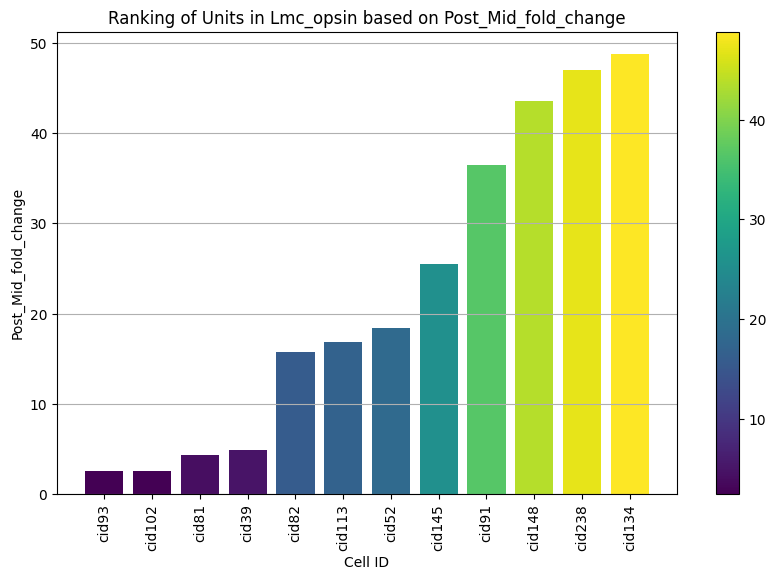

In [90]:
# Plot the ranked units based on a specific metric
analysis_instance.plot_ranked_units('Lmc_opsin', 'Post_Mid_fold_change', ascending=True)

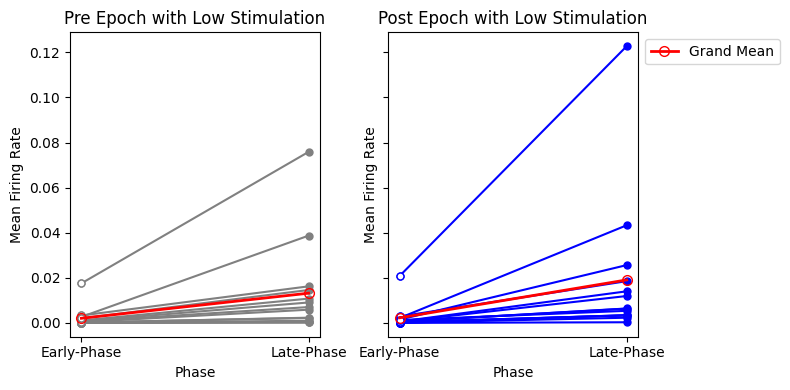

In [91]:
#plot the mean firing rate for the mid stimulation level
analysis_instance.plot_mean_firing('Low', group_name='Lmc_opsin') 



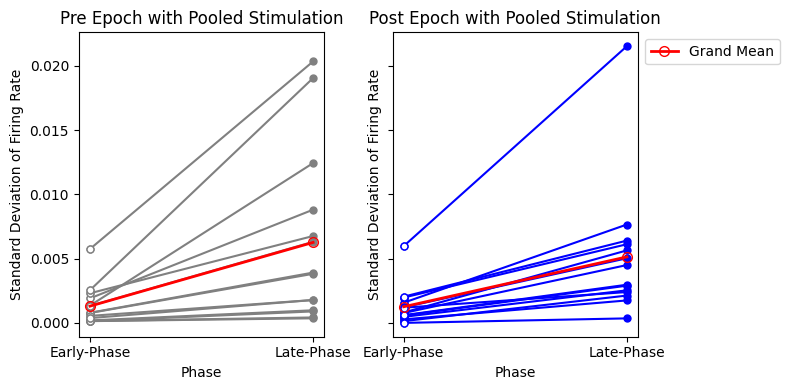

In [92]:
#plot the standard deviation for the mid stimulation level
analysis_instance.plot_standard_deviation('Pooled', group_name='Lmc_opsin')

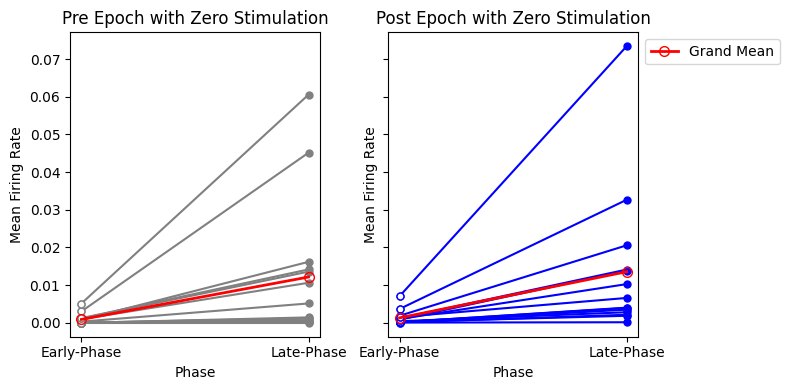

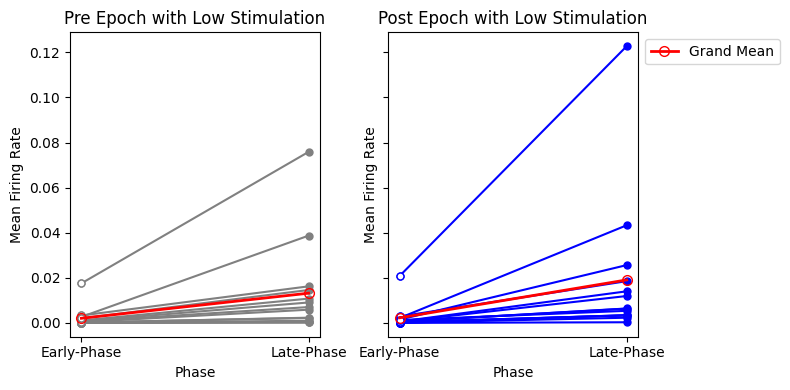

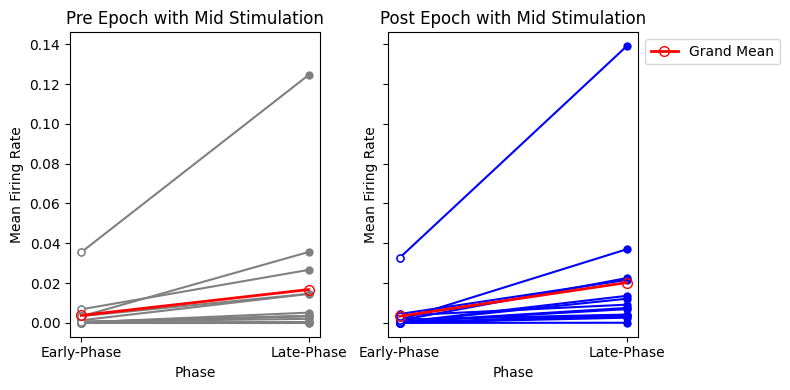

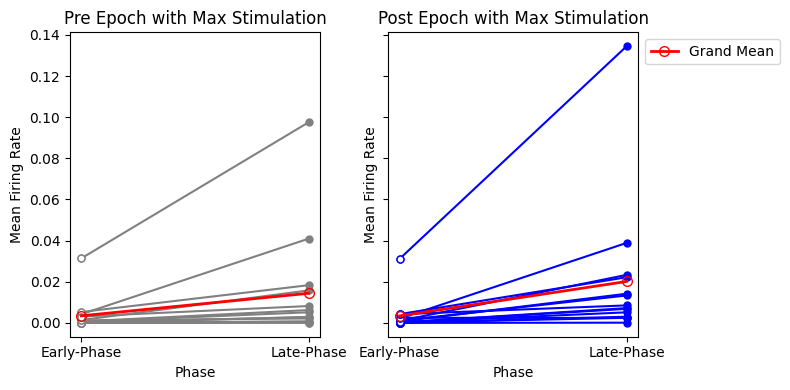

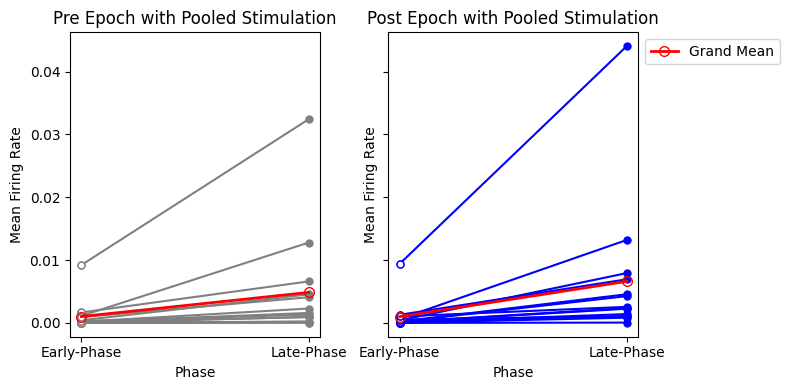

In [93]:
#now iterate for all the stims for the Lmc_opsin group and plot the mean firing rate
for stim in ['Zero', 'Low', 'Mid', 'Max', 'Pooled']:
    analysis_instance.plot_mean_firing(stim, group_name='Lmc_opsin')
    

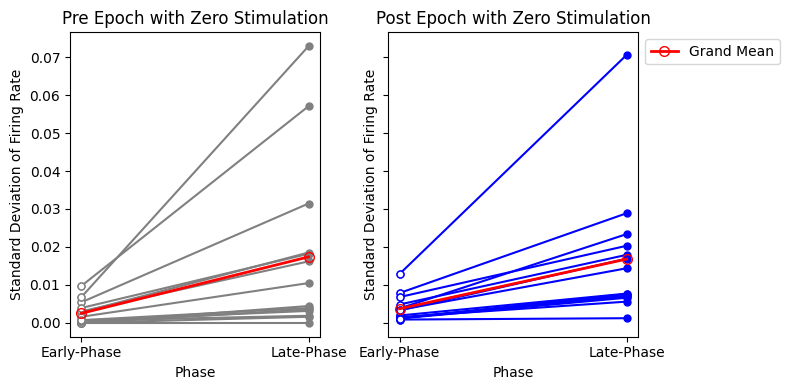

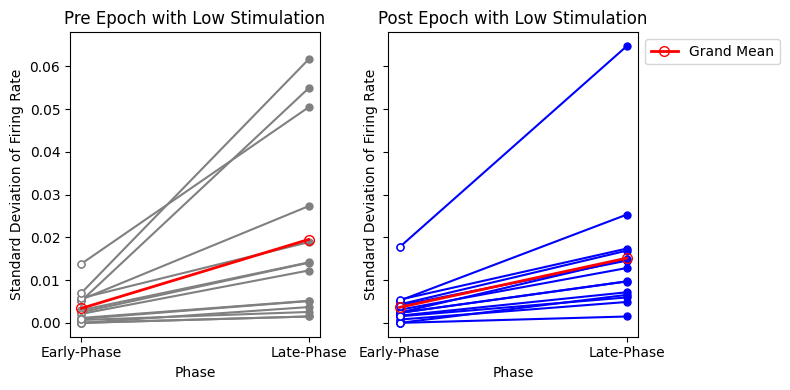

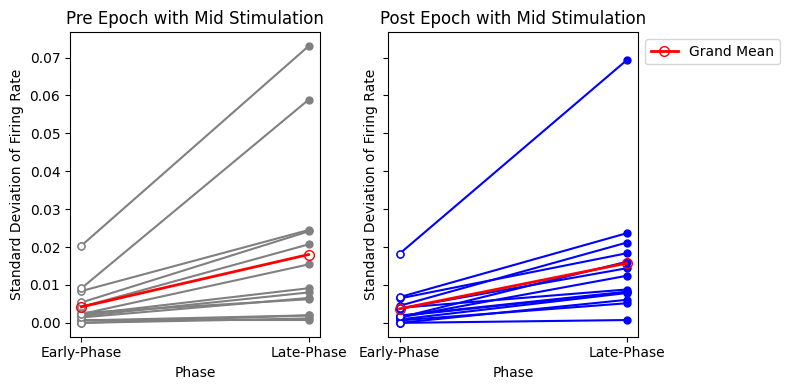

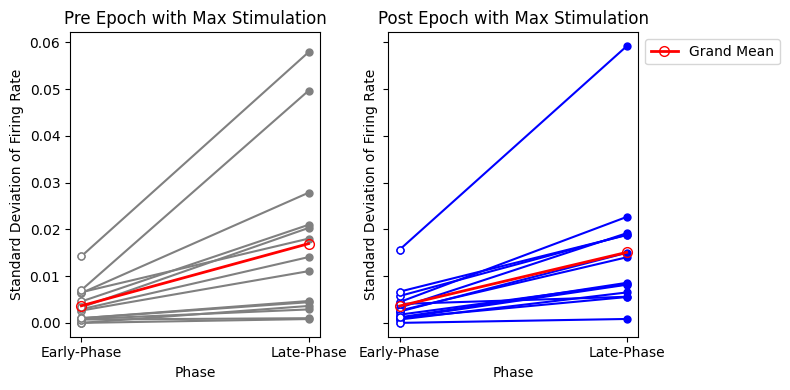

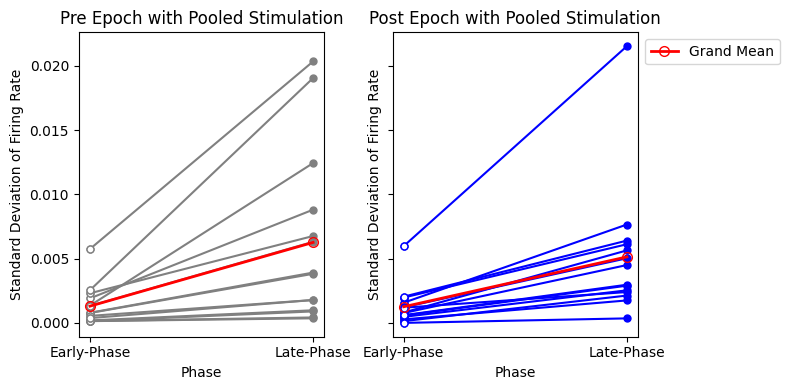

In [94]:
#repeat this for the standard deviation
for stim in ['Zero', 'Low', 'Mid', 'Max', 'Pooled']:
    analysis_instance.plot_standard_deviation(stim, group_name='Lmc_opsin')
    

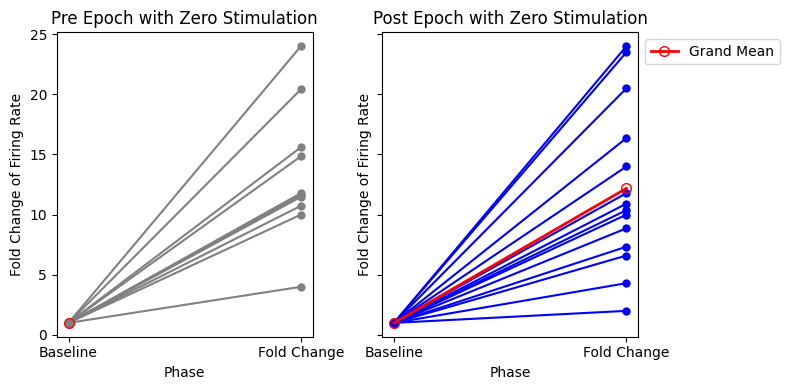

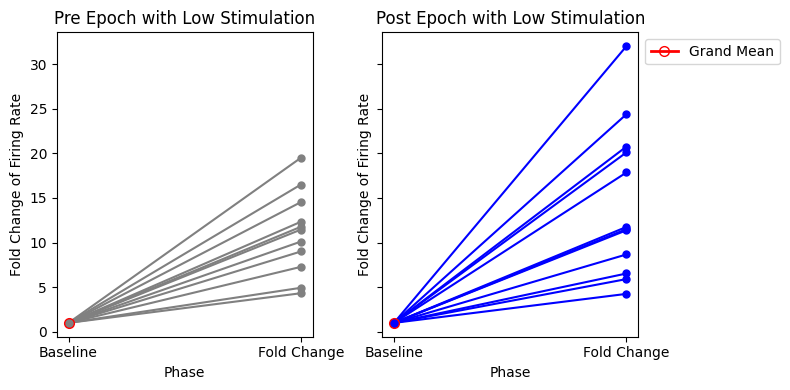

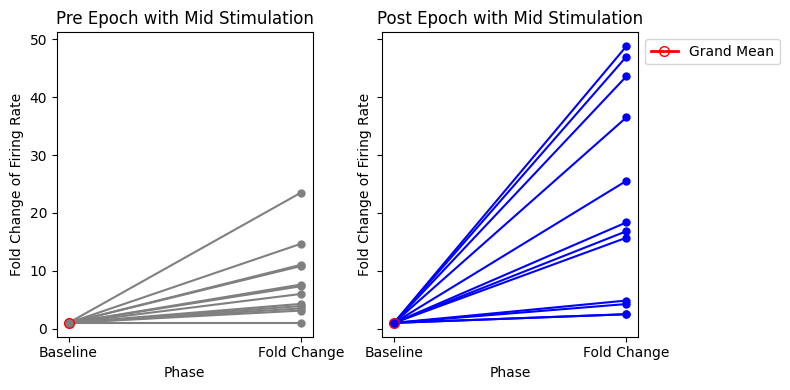

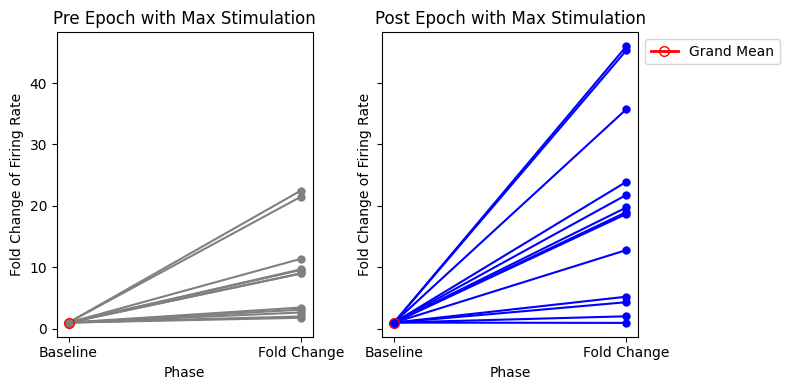

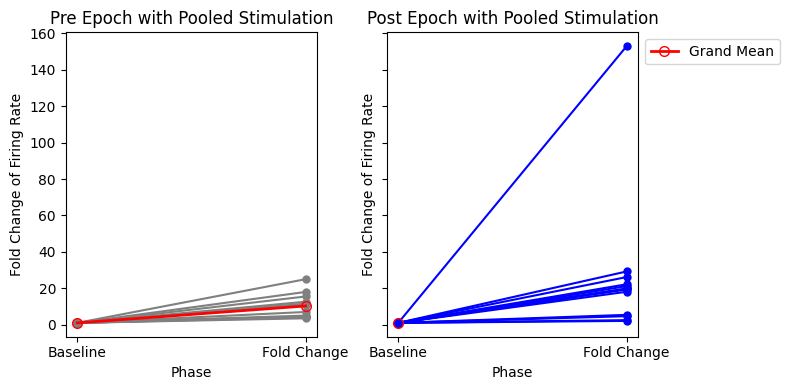

In [95]:
#now plot the fold change for the Lmc_opsin group
for stim in ['Zero', 'Low', 'Mid', 'Max', 'Pooled']:
    analysis_instance.plot_fold_change(stim, group_name='Lmc_opsin')

In [96]:
analysis_instance.plot_fold_change_plotly('Max', group_name='Lmc_opsin')

In [97]:
analysis_instance.plot_standard_deviation_plotly('Low', group_name='Lmc_opsin', data_type='both')

In [98]:
analysis_instance.plot_mean_firing_rate_plotly('Max', group_name='Lmc_opsin')

Removed cell IDs ['cid238', 'cid79'] from group 'Lmc_opsin'.


In [62]:
analysis_instance.plot_fold_change_plotly('Pooled', group_name='Lmc_opsin')


In [63]:
analysis_instance.analysis_df

Recording  CellID  \
Lmc_noopsin cid159  lmc_noch_1_3096_rec1  cid159   
            cid169  lmc_noch_1_3096_rec1  cid169   
            cid24   lmc_noch_1_3096_rec1   cid24   
            cid244  lmc_noch_1_3096_rec1  cid244   
            cid251  lmc_noch_1_3096_rec1  cid251   
            cid21   lmc_noch_1_3096_rec2   cid21   
            cid211  lmc_noch_1_3096_rec2  cid211   
            cid219  lmc_noch_1_3096_rec2  cid219   
            cid22   lmc_noch_1_3096_rec2   cid22   
Lmc_opsin   cid134    lmc_ch_1_3094_rec1  cid134   
            cid145    lmc_ch_1_3094_rec1  cid145   
            cid148    lmc_ch_1_3094_rec1  cid148   
            cid156    lmc_ch_1_3094_rec1  cid156   
            cid52     lmc_ch_1_3094_rec1   cid52   
            cid91     lmc_ch_1_3094_rec1   cid91   
            cid113    lmc_ch_1_3094_rec2  cid113   
            cid82     lmc_ch_1_3094_rec2   cid82   
            cid102    lmc_ch_2_3093_rec1  cid102   
            cid39     lmc_ch_2_3093_rec1   cid39   
            cid81     lmc_ch_2_3093_rec1   cid81   
            cid93     lmc_ch_2_3093_rec1   cid93   

                                                 Pre_Zero_early_phase  \
Lmc_noopsin cid159  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid169  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid24   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid244  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid251  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid21   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid211  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid219  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid22   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
Lmc_opsin   cid134  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid145  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid148  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid156  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid52   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid91   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid113  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid82   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid102  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid39   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid81   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid93   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                                  Pre_Zero_late_phase  \
Lmc_noopsin cid159  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid169  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid24   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid244  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid251  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid21   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid211  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid219  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid22   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
Lmc_opsin   cid134  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid145  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid148  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid156  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid52   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid91   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid113  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
            cid82   [[0, 0, 0, 0, 0, 0

131

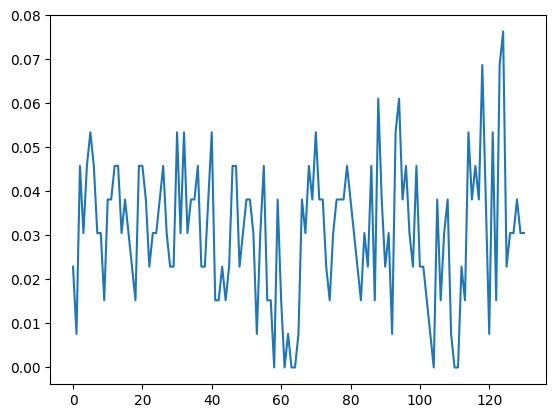

In [99]:
analysis_instance.analysis_df.Post_Zero_late_response
#now grab specifically cid81 and plot the mean firing rate

analysis_instance.analysis_df.loc['Lmc_opsin'].loc['cid81'] #this is a series

#plot the mean firing rate for cid81
plt.plot(analysis_instance.analysis_df.loc['Lmc_opsin'].loc['cid81'].Post_Max_early_response) 
#length of this is? 
len(analysis_instance.analysis_df.loc['Lmc_opsin'].loc['cid81'].Post_Max_early_response)

In [ ]:
#